<h1>IS4242 Group Project</h1>

<b>Import necessary libraries</b>

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

<h5>Running the code</h5>
Ensure that you are in the root folder of all the fold folders and target files
read_text(fold_name):
    fold_name: this is the name of the fold you want to read ALL patient files of. It will be read into a 2 dimensional
    list. If you would like to retrieve just the first patient instead, you will need to change the line 
    "txt_all.extend(txt[1:])" to "txt_all.append(txt[1:])" and you will be to use "read_text(fold1.txt)[0]" to retrieve
    the relevant patient's data
read_ans(file_name):
    file_name: this is the name of the file you want to read ALL targets of. It will be read into a 2 dimensional
    list. To retrieve the first patient's target: read_ans(ans.csv)[0]
put_single_into_dataframe(txt): This functions takes in 2 dimensional list ie the output of read_text(fold1.txt) 
put_multiple_into_dataframe(txt): Multiple is for using it with the output of read_text after you wanted to change it to append


In [2]:
def read_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
                recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
                txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
                txt_all.extend(txt[1:]) # skip the parameter list
    return txt_all

def read_one_text(fold_name):
    txt_all = list()
    for f in os.listdir(fold_name): # for each file in the directory
        if f.endswith(".txt"):
            with open(os.path.join(fold_name, f), 'r') as fp: # open each file
                txt = fp.readlines() # read inside the file
            recordid = txt[1].rstrip('\n').split(',')[-1] # get recordid
            txt = [[int(recordid)] + t.rstrip('\n').split(',') for t in txt] # preface each row with the recordid as all patients are 1 file
            txt_all.append(txt[1:]) # skip the parameter list
    return txt_all

def read_ans(file_name):
    txt_all = list()
    with open(file_name, 'r') as fp: # opens the csv file
        txt = fp.readlines() 
    for i in range(1, len(txt)): # similar to above read_text
        record_id, length_of_stay, hospital_death = txt[i].rstrip('\n').split(',')
        txt_all.append([record_id, length_of_stay, hospital_death])
    return txt_all

def put_multiple_into_dataframe(txt_all):
    df = pd.DataFrame()
    for i in txt_all:
        df2 = pd.DataFrame(i, columns=['recordid', 'time', 'parameter', 'value'])
        df = df.append(df2, ignore_index=True)
    return df

def put_single_into_dataframe(txt_all):
    df = pd.DataFrame(txt_all, columns=['recordid', 'time', 'parameter', 'value'])
    return df

def get_X_add_ready(X_add, stat):
    X_add = X_add.reset_index()
    X_add = X_add.pivot(index='recordid', columns='parameter', values='value')
    X_add = X_add.drop(stat_feat, axis = 1) 
#     X_add = X_add.drop(['RecordID'], axis = 1) 
    X_add.columns = [x+stat for x in X_add.columns]
    X_add = X_add.reset_index()
    return X_add

<h1>1. Data Exploration</h1>

Firstly, read_one_text function is used to read in the folder (eg. Fold1) containing the patient's individual record file. The index 0 in this case in the first line: p1 = read_one_text('../Project_Data/Fold1')[0] is to retrieve the first patient's record in the folder entered inside the function read_one_text. For example, to retrieve the last patient record in Fold3 folder, one has to type: p1 = read_one_text('../Project_Data/Fold3')[999]

Format to get individual record:  
Line 1: p1 = read_one_text('../Project_Data/<b>x</b>')[<b>y</b>]  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>x</b> = folder of the patient to retrieve  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<b>y</b> = index row of the patient inside the folder - 1

Next, this patient record will then undergo preprocessing steps as follows to remove unnecessary information and transform the data into a more meaningful one. This patient record is transformed into dataframe with the columns 'recordid', 'time', 'parameter', 'value'. The recordid of this patient is stored in a variable called 'recordId' before dropping both the column 'recordid' and the first row in the dataframe which contains the recordid of this patient as they are now redundant. 

Subsequently, data in the column for 'value' is converted to numeric so as to facilitate the plotting of graph later. A new column called 'time_value' is created to store a tuple of 'time' and 'value'. The dataframe is then grouped by the 'parameter' column and then the 'time_value' tuple is then stored in a list based on the parameter. 

Finally, the groupby object is then plotted into a graph with each unique parameter as a different line in the graph with the x-axis in hours and y-axis as the values which the parameter is measured.

C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


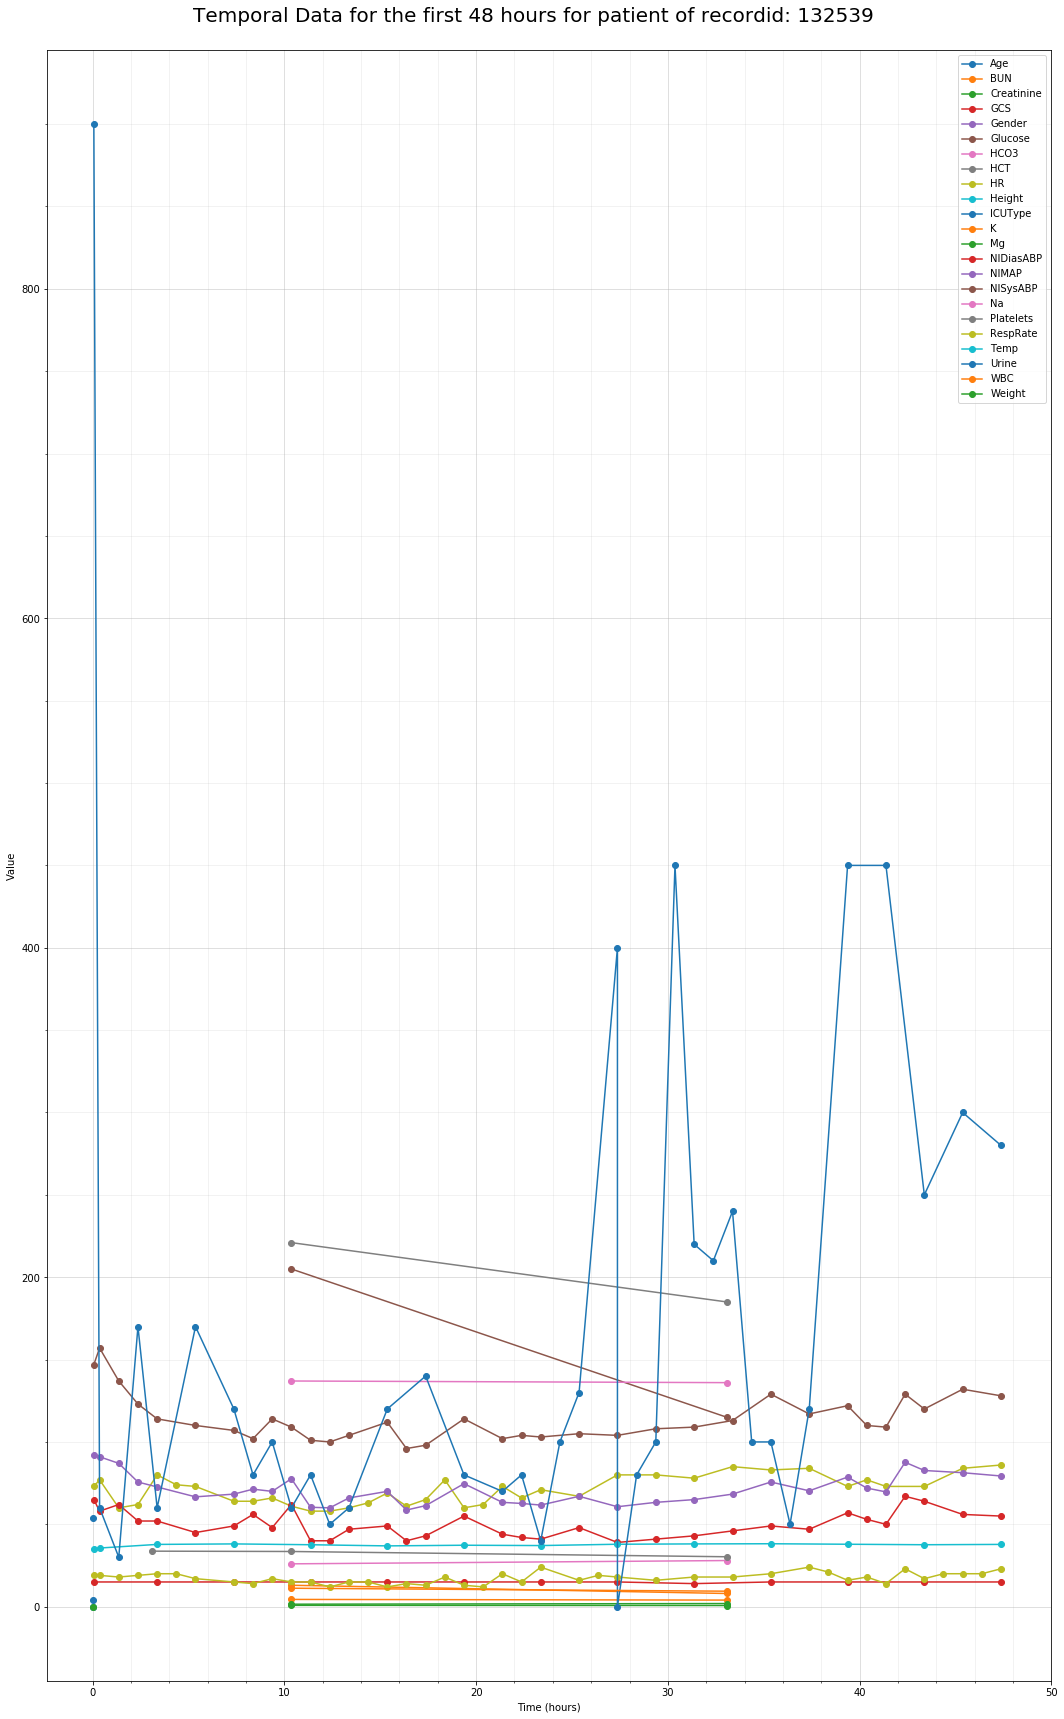

In [3]:
p1 = read_one_text("../Project_Data/Fold1")[0]
p1df = pd.DataFrame(p1, columns=['recordid', 'time', 'parameter', 'value'])
recordId = p1df.iloc[0]['value']
df_1 = p1df.drop('recordid', axis=1)
df_1.drop(df_1.index[:1], inplace=True)
# df_1

df_1['value'] = pd.to_numeric(df_1['value'])
df_1.time = df_1.time.astype('str')
df_1['time'] = df_1['time'].str.replace(':', '.')
df_1['time'] = pd.to_numeric(df_1['time'])
df_1['value'][df_1['value'] < 0] = 0
df_1['time_value'] = list(zip(df_1.time, df_1.value))
df_2 = df_1.groupby('parameter').time_value.apply(lambda x: x.unique().tolist())

major_ticks = np.arange(0, 51, 10)
minor_ticks = np.arange(0, 49, 2)
fig = plt.figure(figsize=(18, 30))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(df_2)):
    testList2 = [(elem1, elem2) for elem1, elem2 in df_2[i]]
    zip(*testList2)
    plt.plot(*zip(*testList2), marker='o', label=df_2.index[i])
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.legend(loc='upper right')
title = 'Temporal Data for the first 48 hours for patient of recordid: ' + recordId
fig.suptitle(title, fontsize=20, y=0.9)
# plt.xlim(xmin=0.0)
# plt.ylim(ymin=0.0)
ax.minorticks_on()
ax.set_xticks(minor_ticks, minor=True)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
# ax.tick_params(which = 'both', direction = 'out')
plt.show()

In [3]:
df_feat = pd.DataFrame()
numberOfFolds = 0
for i, name in enumerate(["Fold1"]): # what folds do you want to use?
    string = "../Project_Data/"
    string += name
    df_feat = df_feat.append(put_single_into_dataframe(read_text(string)))
    numberOfFolds = (i+1)
numberOfRows = numberOfFolds*1000
df_feat.head()

,recordid,time,parameter,value
0,132539,00:00,RecordID,132539
1,132539,00:00,Age,54
2,132539,00:00,Gender,0
3,132539,00:00,Height,-1
4,132539,00:00,ICUType,4


In [4]:
# Reading Target
df_target = pd.DataFrame(read_ans('../Project_Data/Fold1_Outcomes.csv'), columns=['recordid', 'days_in_hospital', 'mortality'])
df_target.head()

,recordid,days_in_hospital,mortality
0,132539,5,0
1,132540,8,0
2,132541,19,0
3,132543,9,0
4,132545,4,0


In [5]:
bin_feat = ['MechVent']
num_feat = ['Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol',
           'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT',
           'HR', 'K', 'Lactate', 'Mg', 'MAP', 'NA', 'NIDiasABP', 'NIMAP',
           'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate', 'SaO2',
           'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight']

print("Number of record ids:", len(df_feat['recordid'].unique()))
unique_count = df_feat['parameter'].value_counts()/numberOfRows
print(unique_count)

Number of record ids: 1000
HR             57.027
MAP            36.092
SysABP         35.979
DiasABP        35.955
Urine          34.208
Weight         33.679
NISysABP       24.457
NIDiasABP      24.424
NIMAP          24.088
Temp           21.204
GCS            15.214
RespRate       13.775
FiO2            7.815
MechVent        7.596
pH              5.770
PaO2            5.496
PaCO2           5.490
HCT             4.626
K               3.708
Creatinine      3.573
Platelets       3.566
BUN             3.547
HCO3            3.479
Mg              3.468
Na              3.462
Glucose         3.338
WBC             3.286
SaO2            1.985
Lactate         1.924
Height          1.000
RecordID        1.000
ICUType         1.000
Gender          1.000
Age             1.000
Bilirubin       0.858
AST             0.857
ALT             0.857
ALP             0.833
Albumin         0.617
TroponinT       0.566
TroponinI       0.130
Cholesterol     0.077
Name: parameter, dtype: float64


<h2>Analysis of Features</h2>
<p>The data above shows the average number of times a variable observed per patient. Based on the data above and the feature description we classify the features into these categories:
<ul>
    <li>General Descriptors (static data) that are collected when the patient is admitted to the ICU. Weight is not included as weight are measured multiple times as a time series data. Each of the descriptors will be included as a feature into the model.</li>
    <li>Rare features: measured on average less than one time per patient (less than 1.0). We use the <u>existence</u> of these measurements for each patient as a feature.</li>
    <li>Features that measured often or more that one time per patient (more than 1.0). Calculate the hourly average of each measurements and put them into 48 columns. <i>Example, average HR on the first hour to HR_1, average HR on the second hour to HR_2, and so on.</i></li>
</ul>
</p>


In [6]:
stat_feat = ['Age', 'Gender', 'Height', 'ICUType', 'RecordID'] #General Descriptors
rare_feat = []
nor_feat = []
for index, value in unique_count.items():
    if value < 1.0:
        rare_feat.append(index)
    elif index not in stat_feat:
        nor_feat.append(index)
rare_feat.append("MechVent")
print("Rare features", rare_feat)
print("Normal features", nor_feat)

Rare features ['Bilirubin', 'AST', 'ALT', 'ALP', 'Albumin', 'TroponinT', 'TroponinI', 'Cholesterol', 'MechVent']
Normal features ['HR', 'MAP', 'SysABP', 'DiasABP', 'Urine', 'Weight', 'NISysABP', 'NIDiasABP', 'NIMAP', 'Temp', 'GCS', 'RespRate', 'FiO2', 'MechVent', 'pH', 'PaO2', 'PaCO2', 'HCT', 'K', 'Creatinine', 'Platelets', 'BUN', 'HCO3', 'Mg', 'Na', 'Glucose', 'WBC', 'SaO2', 'Lactate']


In [7]:
# your code to produce test and train data
df = df_feat.copy()

<h2>Creation of Data Matrices</h2>
<p>We create 3 different matrices to convert temporal data into a matrix that is a single feature vector per patient.</p>
<h3>First Design Matrix</h3>
<ul> 
    <li>In the cell below, we create a matrix that generalises a patient's attributes across the whole 48 hours, such as his max BUN measurement over the 48 hours. This is so as to create a much denser feature matrix as well as provide a much clearer signal to the learner, allowing it to generalise to data outside of the train set.</li>
    <li>We will be utilising the min, max and mean of the measurements</li>
    <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [8]:
def preprocess_x_for_design_matrix_1(df_feat):
    non_bin_feat.clear()
    # your code to produce test and train data
    df = df_feat.copy()

    df['value'] = pd.to_numeric(df['value'])
    temp_df = df.loc[df['time'] == '00:00', :].copy() # get all the variables at time 0
    temp_df = temp_df.loc[temp_df['parameter'].isin(stat_feat)] # prune the dataframe to only those static variables
    temp_df = temp_df.pivot(index='recordid', columns='parameter', values='value') 
    temp_df = temp_df.reset_index()
    for i in temp_df: # for loop to change all the -1 values for static variables into np.nan
        idx = temp_df.index[temp_df[i] == -1].tolist()
        for j in idx:
            temp_df.loc[j, i] = np.nan
    final_df = temp_df.copy()

#     Dealing with rare_feat
    d = df_feat.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id
    for x in rare_feat:
        id = specialFeature(x)
        final_df[x] = 0
        for i in id:
            for row in final_df.index:
                if row == i:
                    final_df.loc[row, x] = 1
    final_df = final_df.drop(["RecordID"],axis=1)

    # Getting the different attributes
    pd.set_option('display.max_columns', 500)
    temp_df = df.drop(df.index[df['parameter'].isin(rare_feat)].tolist())
    temp_df = temp_df.groupby(['recordid', 'parameter'])[['value']]
    for i in ['min', 'max', 'mean']: # the different parameters we will use
        if (i=='min'):
            X_add = temp_df.min() # get the min of each parameter
            X_add = get_X_add_ready(X_add, '_min')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='max'):
            X_add = temp_df.max() # get the max of each parameter
            X_add = get_X_add_ready(X_add, '_max')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe
        elif (i=='mean'):
            X_add = temp_df.mean() # get the mean of each parameter
            X_add = get_X_add_ready(X_add, '_mean')
            final_df = final_df.merge(X_add, left_on='recordid', right_on='recordid') # merge the min of the parameters to the final dataframe

    # dealing with ICUType categorical
    one_hot = pd.get_dummies(final_df['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    final_df = final_df.merge(one_hot, left_index=True, right_index=True)
    final_df = final_df.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in final_df.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan


    # Drop recordID column
    final_df = final_df.drop("recordid", axis=1)
            
    # Creating non binary column list and filling na values with mean
    for i in final_df:
        if i in rare_feat or i in bin_feat:
            continue
        final_df = final_df.fillna(final_df.mean())
        non_bin_feat.append(i)
        
#     display(final_df.head())
    return final_df

<h3>Second Design Matrix</h3>
<ul> 
    <li>The second design matrix is created in such a way that every parameters is grouped into a 12-hour bin (eg. 0-12, 12-24, 24-36, 36-48). If a parameter is measured multiple times within a 12-hour bin, a mean of those measurement will be recorded to represent the measurement for that 12-hour bin instead. The assumption for using the mean for 12-hour is that once patients are sent to the ICU, they must be closely monitored and furthermore, the working shift of nurses in hospital is usually by 12-hour and so this ensures lesser human errors when the nurses change shift and patient is being measured.</li>
        <li>We have converted sparse features like ALS into a binary variable where 1 represents "It was recored" and 0 representing "It was not recorded at all".</li>
    <li>ICUType was one-hot encoded</li>
</ul>

In [29]:
# Second Matrix
def preprocess_x_for_design_matrix_2(df):
    non_bin_feat.clear()
    
    # retrieving static data of the patients at time 0 and transformed into dataframe with static feature as the column 
    # headers and each row in the dataframe representing each patient record, which is indexed by their record id
    df_static = df.loc[df['time'] == '00:00', :].copy()
    static_vars = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    df_static.drop('time', axis=1, inplace=True)
    df_static = df_static.loc[df_static['parameter'].isin(static_vars)]
    df_static = df_static.groupby(['recordid', 'parameter'])[['value']].last()
    df_static.reset_index(inplace=True)
    df_static = df_static.pivot(index='recordid', columns='parameter', values='value')

    for c in df_static.columns:
        df_static[c] = pd.to_numeric(df_static[c])

    # replacing height and weight which does not exist (represented with '-1') with NaN
    for c in df_static.columns:
        x = df_static[c]
        if c == 'Height':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
        elif c == 'Weight':
            idx = x < 0
            df_static.loc[idx, c] = np.nan
    d = df.groupby(['recordid', 'parameter'])[['value']].count()
    def specialFeature(special):
        id = []
        for index, row in d.iterrows():
            if index[1] == special:
                id.append(index[0])
        return id

    # RecordID column is dropped as every row is already indexed by the recordid
    df2 = df_static.copy()
    df2.drop('RecordID', axis=1, inplace=True)

    # rare features which are rarely measured such as Cholesterol are converted to binary features which indicates whether 
    # any measurement for these variables were recorded within the first 48 hours. Binary feature was also created for 
    # MechVent to indicate whether the patient was placed on mechanical ventilation
    for x in rare_feat:
        id = specialFeature(x)
        df2[x] = 0
        for i in id:
            for row in df2.index:
                if row == i:
                    df2.loc[row, x] = 1
    df2.head()
    normal_feat = nor_feat.copy()
    normal_feat.remove('MechVent')
    
    # grouped the rest of the parameters into 12-hour bins and the mean of the parameter in a given 12-hour interval
    # is taken if it was measured more than once during that 12-hour interval
    idx = df['parameter'].isin(normal_feat)
    df3 = df.loc[idx, :].copy()
    df3[['hour','min']] = df3.time.str.split(':', expand=True)
    df3["hour"] = pd.to_numeric(df3["hour"])
    df3["value"] = pd.to_numeric(df3["value"])
    bins = [0, 12, 24, 36, 48]
    labels = ['0', '12', '24', '36']
    
    # grouped by recordid first, then by each 12-hour interval then by the parameters
    df3 = df3.groupby(['recordid', pd.cut(df3.hour, bins=bins, labels=labels), 'parameter'])[['value']].mean()
    df3

    # filled in the dataframe with NaN first
    for n in normal_feat:    
        df2[n +'0'] = np.nan
        df2[n +'12'] = np.nan
        df2[n +'24'] = np.nan
        df2[n +'36'] = np.nan
    df2.head()

    # go through every row in groupby table and insert these values into the dataframe with NaN, replacing them
    for index, row in df3.iterrows():
        recordId = index[0]
        hour = index[1]
        parameter = index[2]
        df2.loc[recordId, parameter+hour] = row["value"]

    one_hot = pd.get_dummies(df2['ICUType'])
    meaning_of_icu_types = {1:'Coronary Care Unit', 2: 'Cardiac Surgery Recovery Unit', 3: 'Medical ICU', 4: 'Surgical ICU'}
    one_hot.columns = [meaning_of_icu_types[x] for x in one_hot.columns]
    df2 = df2.merge(one_hot, left_index=True, right_index=True)
    df2 = df2.drop('ICUType', axis=1)
    
    # Extreme height values is set to np.nan
    for index, row in df2.iterrows():
        if row["Height"] < 40 or row["Height"] > 210:
            row["Height"] = np.nan
            
    # Creating non binary column list and filling na values with mean
    for i in df2:
        if i in rare_feat or i in bin_feat:
            continue
        df2 = df2.fillna(df2.mean())
        non_bin_feat.append(i)

    display(df2.head())
    return df2

<h3>Third Design Matrix</h3>
<p>This design matrix splits all numerical time series data into hourly bins. The average value of the measurements on each hour will be taken and put into the columns. The idea of this is to get the condition of the patient on each hour from coming in to the hospital until the 48 hour mark. All rare features will be taken as a binary feature of whether the measurement appear within 48 hours. All general descriptors taken as it is except weight.</p>

In [8]:
def preprocess_x_for_design_matrix_3(df_feat):
    df = pd.DataFrame()
    
    tot_values = {} # the sum of the values
    count = {} # num of occurences of a measurement
    for index,row in df_feat.iterrows():
        if row['parameter'] == 'RecordID' and index != 0:
            # count the average of the previous record
            for key,value in tot_values.items():
                tot_values[key] = float(tot_values[key])/count[key]

            df = df.append(tot_values, ignore_index=True)
            tot_values.clear()
            count.clear()
            for feat in rare_feat:
                tot_values[feat] = 0;
                count[feat] = 1;

        if row['parameter'] in stat_feat:
            tot_values[row['parameter']] = row['value']
            count[row['parameter']] = 1
        elif row['parameter'] in rare_feat:
            tot_values[row['parameter']] = 1
            count[row['parameter']] = 1
        elif row['parameter'] in nor_feat and row['parameter'] != 'MechVent':
            hour = int(row['time'][0:2]) + 1
            if hour == 49: hour-=1
            col = row['parameter'] + '_' + str(hour)
            tot_values[col] = row['value']
            if col in count:
                count[col] = count[col] + 1
            else:
                count[col] = 1

    # count the average of the previous record
    for key,value in tot_values.items():
        tot_values[key] = float(tot_values[key])/count[key]

    df = df.append(tot_values, ignore_index=True)
    
    df = df.astype({'RecordID': 'int32', 'ICUType':'int32'})
    
    return df

<h1>Model Building for M1</h1>
<p>We develop models for our design matrix.</p>

<p>We have several common steps for all 3 model building which we will list. If there are any particularities, it will be further described at the respective model. Here are the steps.
    <ol>
        <li><b>Imputation</b>
            <ul>
                <li>Categorical: we impute empty data with the most frequent appearing value of that feature. Mean or median is not used for categorical because the value of a categorical feature doesn't depend on how big or small the value is but the value represents a category of that feature.</li>
                <li>Numerical: we impute the data with the mean value of the feature.</li>
            </ul>
        </li>
        <li><b>One-Hot Encoder</b> <i>(only for Categorical features)</i>
            <br>One-Hot encoding is used to replace the categories inside a categorical feature into multiple binary features. The purpose of this is to make sure that the model is not biased into thinking bigger values mean better categories. Example: A categorical feature has values 1,2,3 represents animals such as Dog, Cat, and Fish respectively. Say the model is counting the average of those numbers, then it can means the average of 1 and 3 is 2. Which equals to Dog and Fish on average is Cat which is obviously not true. Some models may have implemented this step in the creation of the design matrix already.</br>
            </li>
        <li><b>Scaler</b>
            <br>The data in this case is on different scale meaning some numbers are bigger than the others. The model might weigh the bigger values higher. To reduce this problem, we scale the data.
            </br>
        </li>
        <li><b>SelectKBest</b>
            <br>SelectKBest is used to extract features which is actually important for our prediction. There are a lot of features for some matrices (1400+) and some features might not be as influencing for our model. SelectKBest selects K best features that is useful for the model.</br>
        </li>
        <li><b>Variance Threshold</b>
            <br>Similar to how SelectKBest is used to extract features, where we work off the idea that when a feature doesn’t vary much within itself, it generally has very little predictive power.</br>
        </li>
        <li><b>Dimensionality Reduction</b>
            <br>We understand that some features might be overlapping each other. We used PCA to extract the principle features to reduce redundant features.</br>
        </li>
        <li><b>Classifier Model</b>
            <br>We select our classifier model empirically based on which model has the best results on average across all folds. There are multiple learners we use that will be listed below.</br>
        </li>
    </ol>
    <p>We run <b>GridSearchCV</b> on our training data to optimize our hyperparameters. Our hyperparameter optimization is based on the ROC AUC or Mean Squared Error score. Hyperparameter optimization is important because each set of steps in our pipeline has different values such as the learning rate, K value for SelectKBest, or number of components at PCA, and each values will give different results and some are better than the others. We use this method mainly as way to find the best learner algorithm to use for M2.</p>


In [25]:
# preprocess y dataframe for use in linear regression
def preprocess_y_linear(temp_df):
    temp_df = temp_df.drop(['recordid','mortality'], axis=1)
    temp_df['days_in_hospital'] = pd.to_numeric(temp_df['days_in_hospital'])
    for index, row in temp_df.iterrows():
        if row['days_in_hospital'] == -1:
            row['days_in_hospital'] = 2   
    return temp_df

# preprocess y dataframe for use in classification
def preprocess_y_class(temp_df):
    temp_df = temp_df.drop(['recordid','days_in_hospital'], axis=1)
    temp_df['mortality'] = pd.to_numeric(temp_df['mortality'])  
    return temp_df

bin_feat = ["Gender", "Coronary Care Unit", "Cardiac Surgery Recovery Unit", "Medical ICU", "Surgical ICU"]
non_bin_feat = []
scaler = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('num', StandardScaler(), non_bin_feat)])
all_list = [1,2,3,4]

<h3>First Model</h3>
<ul> 
    <li>First, in the cell below, we make use of the first design matrix above to pass in as input to the models. Training is done on 3 folds and a test I.E. validation on the remaining fold. Included is 3 regresssion models (Linear, DecisionTree, MLP) and 3 classification models (AdaboostedDecisionTrees, MLP, GaussianNB). </li>
</ul>

In [10]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_1(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

<h4>Regressor Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare different regression models based on the mean squared error. The three classifiers are Linear Regression, DecisionTreeRegressor and MLPRegressor.</br>
    </li>
</ol>
    

In [22]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 
matrix_class = [[0 for x in range(w)] for y in range(h)] 

param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[j])
        y_train_class_df = y_train_class_df.append(folds_y_class[j])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {
                  'dim_reducer__n_components':[60,70]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {
                  'dim_reducer__n_components':[60,70],
                  'classifier__min_samples_leaf':[1,3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = { 
                  'dim_reducer__n_components':[60,70],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5), (130, 100, 50)],
                  'classifier__learning_rate_init':[0.9, 0.105]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor(max_iter=700))])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

<h4>Classifier Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>SMOTE</b></li>
    <li><b>Dimensionality Reducer with Variance Threshold</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the mean roc_auc_score error. The three classifiers are KNeighbours, Logistic Regression and RandomForestClassifier.</br>
    </li>
</ol>
    

In [26]:
all_list = [1,2,3,4]
for i in range(1,5):
    # KNeighbours
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_neighbors':[3,2]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', KNeighborsClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='roc_auc')
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][0] = (roc_auc_score(y_test_class_df, prediction))
    
    # Logistic Regression
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LogisticRegression())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][1] = (roc_auc_score(y_test_class_df, prediction))
    
    # RandomForestClassifier
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60],
                  'classifier__n_estimators':[10,15]
                 }
    est = imPipeline(steps=[
            ('smote', SMOTE()),
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', RandomForestClassifier())])
    estimator = GridSearchCV(est, parameters, cv=3)
    estimator.fit(x_train_df, y_train_class_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix_class[i-1][2] = (roc_auc_score(y_test_class_df, prediction))

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\v

C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

<h4>Results</h4>

In [27]:
number_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
score_class_df = pd.DataFrame(matrix_class, columns=["KNeighbour", "Logistic", "RandomForests",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:4,i].mean())
    score_class_df.iloc[4,i] = score_class_df.iloc[0:4,i].mean()
display(score_df)
display(score_class_df)

,Linear,DecisionTree,MLPRegressor,
0,181.931888,319.447198,200.483845,0
1,126.571049,255.426125,137.452468,0
2,128.414533,218.447538,139.760740,0
3,237.443435,251.121457,119.134381,0
4,12.984230,16.158916,12.215067,0


,KNeighbour,Logistic,RandomForests,
0,0.557483,0.695993,0.544187,0
1,0.553577,0.687142,0.540281,0
2,0.553003,0.685314,0.549814,0
3,0.541284,0.691621,0.566693,0
4,0.551337,0.690018,0.550244,0


<h3>Second Model</h3>
<ul> 
    <li>We make use of the second Design matrix described above on the same parameters that we tried in the Model building 1.</li>
</ul>

In [30]:
# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_2(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
132539,54,0,170.094476,81.422068,0,0,0,0,0,0,0,0,0,65.454545,66.090909,78.833333,78.571429,80.711313,79.358527,80.922914,81.500853,115.156032,118.234776,120.376778,121.372441,58.554776,58.822952,59.476010,59.876609,92.000000,86.250000,173.333333,308.333333,82.648197,83.383737,83.651991,83.759171,111.700000,104.125000,111.333333,120.875000,50.600000,45.125000,44.333333,56.125000,70.967000,64.792500,66.666667,77.708750,37.833333,37.100000,38.066667,37.766667,15.000000,15.0,14.666667,15.00,16.545455,15.545455,17.857143,19.636364,0.575987,0.509855,0.506165,0.500966,7.422229,7.390886,7.565855,7.394966,167.119732,128.397906,121.516945,119.794255,40.839626,39.716565,39.386531,39.795741,33.600,31.031831,30.30,30.158595,4.400000,4.168752,4.000000,4.114329,0.8,1.507457,0.70000,1.479688,221.000000,201.597978,185.000000,180.177778,13.0,26.8623,8.000000,27.386189,26.0,23.545873,28.000000,24.082561,1.5,2.038096,1.900000,2.070901,137.000000,139.053437,136.000000,138.672271,205.000000,131.459169,115.000000,133.509428,11.2,12.730003,9.400000,12.236603,97.184859,96.87319,96.396396,96.604748,2.575443,2.395522,2.447271,2.711155,0,0,0,1
132540,76,1,175.300000,76.000000,0,0,0,0,0,0,0,0,1,87.076923,80.055556,75.307692,73.636364,75.740741,76.111111,78.384615,80.111111,106.714286,114.222222,119.923077,123.222222,60.892857,56.888889,57.846154,58.222222,158.933333,103.181818,170.714286,187.500000,82.648197,80.600000,80.600000,81.236364,117.173844,111.750000,115.142857,107.333333,57.986820,57.500000,61.000000,45.666667,76.655203,75.580000,79.047143,66.223333,36.688462,37.500000,36.850000,36.800000,10.800000,15.0,14.666667,14.25,19.613425,19.551701,19.646032,19.636608,0.560000,0.509855,0.506165,0.500966,7.385000,7.400000,7.565855,7.385000,226.250000,128.397906,121.516945,111.000000,37.000000,39.716565,39.386531,45.000000,27.625,28.900000,30.70,29.450000,4.154586,4.300000,4.057783,3.500000,0.8,1.200000,1.50415,1.300000,190.333333,187.000000,191.404915,135.000000,16.0,18.0000,28.141693,21.000000,21.0,22.000000,23.815756,24.000000,3.1,1.900000,2.061273,2.100000,139.341443,139.000000,139.309433,135.000000,150.083243,105.000000,132.354891,146.000000,7.4,13.100000,12.469809,13.300000,98.000000,97.00000,96.396396,95.000000,2.575443,2.395522,2.447271,2.711155,0,1,0,0
132541,44,0,170.094476,56.700000,1,1,1,1,1,0,0,0,1,90.000000,83.250000,87.666667,71.166667,80.711313,79.358527,100.000000,87.250000,115.156032,118.234776,137.500000,121.750000,58.554776,58.822952,75.500000,64.333333,111.818182,185.500000,150.000000,58.800000,56.700000,56.700000,56.700000,56.700000,132.812500,136.750000,124.500000,119.505340,78.750000,80.583333,76.000000,57.339935,96.767500,99.305000,92.163750,76.900645,37.825000,37.233333,38.300000,37.833333,7.333333,6.0,5.000000,5.00,19.613425,19.551701,19.646032,19.636608,0.750000,0.500000,0.460000,0.400000,7.

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
135076,56,1,177.80000,110.0,1,1,1,1,0,0,0,0,1,104.416667,110.777778,104.454545,81.250000,104.777778,116.714286,148.500000,112.750000,147.000000,161.571429,156.000000,133.142857,81.333333,90.142857,111.000000,84.285714,161.428571,125.714286,131.666667,126.000000,81.345255,108.1,108.1,108.1,120.500000,158.875000,148.272727,146.000000,66.500000,70.375000,77.818182,76.090909,84.510000,99.862500,101.308182,99.390909,38.066667,37.600000,37.70000,37.850000,7.000000,11.75,10.166667,8.2,19.424873,19.622286,19.55034,19.782182,0.600000,0.507617,0.515098,0.50479,7.315000,7.430,7.394394,7.430000,219.000000,103.000000,116.867607,74.000000,46.000000,36.000000,39.657571,39.000000,40.100000,37.700000,30.961398,37.800000,4.30000,3.600000,4.053152,3.950000,0.600000,0.8,1.449714,0.700000,228.000000,188.00000,194.81982,231.00000,12.00000,13.0,26.487741,15.500000,23.000000,25.000000,23.775188,25.500000,1.7,1.700000,2.051234,2.000000,140.000000,139.000000,138.878042,143.000000,114.000000,141.000000,130.070914,119.000000,14.40000,15.900000,12.230936,16.000000,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,0,1
135077,72,1,169.30233,220.0,0,0,0,0,1,0,0,0,1,70.428571,87.714286,78.250000,98.727273,64.285714,75.714286,94.250000,97.272727,101.000000,122.071429,142.000000,153.000000,48.428571,53.714286,69.166667,65.636364,83.500000,1.363636,4.133333,5.230769,117.142857,100.0,100.0,100.0,117.325730,115.694079,160.000000,119.579156,58.746771,57.478308,70.000000,57.771990,76.931481,75.786899,100.000000,77.191414,37.766667,38.280000,38.24000,37.700000,9.000000,13.80,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.420000,0.400000,0.550000,0.66000,7.260000,7.316,7.320000,7.258000,129.500000,117.800000,104.000000,128.000000,43.500000,40.000000,38.000000,45.600000,33.300000,31.147414,32.100000,30.054173,5.70000,5.000000,4.900000,4.800000,2.200000,3.9,4.600000,5.000000,167.000000,199.19211,150.00000,176.60216,24.00000,31.0,36.000000,39.000000,20.000000,17.000000,17.000000,19.500000,1.9,2.052855,2.100000,2.200000,138.000000,139.000000,140.000000,140.500000,100.000000,102.000000,119.000000,98.000000,10.10000,12.437016,13.200000,12.394275,97.027244,96.526403,96.56986,96.444055,2.695739,2.383319,2.131766,2.090862,0,0,1,0
135079,68,1,169.30233,100.0,0,0,0,0,0,1,0,0,1,72.739130,88.076923,79.666667,78.909091,76.608696,80.384615,84.750000,82.254622,116.652174,123.846154,129.916667,122.600009,54.391304,57.230769,60.000000,60.724172,161.785714,115.833333,96.666667,99.090909,103.800000,103.8,104.2,104.9,108.666667,115.694079,118.492021,128.000000,57.666667,57.478308,58.259040,63.636364,70.000000,75.786899,77.178522,79.545455,36.485714,37.275000,36.45000,36.500000,7.250000,14.00,15.000000,15.0,19.424873,19.622286,19.55034,19.782182,0.433333,0.507617,0.515098,0.50479,7.325000,7.340,7.394394,7.396834,1

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137593,57,1,157.500000,88.60,0,0,0,0,0,0,0,0,1,98.931034,90.428571,90.000000,87.181818,71.310345,72.285714,67.235294,73.230769,106.482759,112.357143,105.000000,115.538462,56.068966,53.571429,50.176471,55.769231,257.916667,55.833333,130.454545,62.500000,82.704345,89.0,89.0,88.200000,116.815217,116.953677,118.307963,120.750541,58.166331,57.120246,57.762168,57.936709,76.704493,76.099618,76.978834,77.800938,38.373077,38.214286,37.821429,37.266667,10.800000,15.000000,15.000000,14.500000,19.736448,19.336067,19.339250,19.523698,0.600000,0.400000,0.850000,0.700000,7.391250,7.370000,7.380000,7.420000,168.250000,125.811658,85.250000,88.500000,45.125000,39.343704,46.000000,50.00000,31.200000,34.300000,30.446855,30.300000,4.500000,4.600000,4.048392,3.700000,0.600000,0.600000,1.407454,0.700000,214.000000,229.000000,194.35375,171.500000,11.000000,9.000000,27.093275,16.000000,27.000000,27.00000,23.755556,30.00,2.300000,2.000000,1.90000,2.300000,139.093356,137.000000,139.313275,137.500000,170.000000,186.000000,131.240753,131.223025,14.600000,17.400000,12.216938,16.400000,97.800000,96.471630,95.333333,96.002072,2.479119,2.372085,2.039958,2.086082,0,1,0,0
137594,87,1,170.425096,72.50,0,0,0,0,0,0,0,0,0,65.800000,68.222222,66.500000,65.428571,84.000000,79.843976,80.927647,82.065406,151.000000,118.389228,120.700257,123.362393,55.000000,59.625315,60.037273,60.544665,75.142857,97.777778,244.000000,152.500000,72.500000,72.5,72.5,72.500000,135.000000,142.777778,136.833333,134.142857,56.684211,49.555556,51.333333,42.285714,82.792105,80.630000,79.833333,72.905714,36.625000,37.050000,36.900000,36.300000,13.142857,12.777778,11.142857,12.142857,14.421053,15.444444,14.333333,15.000000,0.591333,0.516785,0.520443,0.506305,7.366538,7.388928,7.397845,7.399595,160.449835,125.811658,117.976143,113.725108,40.434075,39.343704,39.350542,40.04247,31.900000,34.700000,36.100000,36.300000,4.122413,3.500000,3.900000,3.800000,1.316559,0.800000,0.900000,0.800000,210.566486,251.000000,241.00000,248.000000,26.151555,18.000000,18.000000,16.000000,22.950528,26.00000,27.000000,27.00,1.980247,1.800000,1.90000,1.800000,139.093356,138.000000,142.000000,140.000000,148.218042,101.000000,115.000000,92.000000,13.251714,11.600000,10.500000,11.100000,96.384891,96.471630,96.133857,96.002072,2.479119,2.372085,2.039958,2.086082,0,0,1,0
137595,73,0,165.100000,77.27,1,1,1,1,0,0,0,0,1,83.275862,89.600000,92.166667,87.909091,77.250000,83.600000,87.250000,80.454545,105.413793,125.066667,136.166667,119.727273,60.482759,65.333333,66.166667,59.363636,261.071429,225.000000,164.583333,218.636364,82.704345,92.7,92.7,91.609091,88.000000,116.953677,118.307963,120.750541,48.000000,57.120246,57.762168,57.936709,61.330000,76.099618,76.978834,77.800938,35.655172,37.775000,38.358333,37.763636,3.000000,7.666667,10.000000,11.000000,19.736448,19.336067,19.339250,19.523698

,Age,Gender,Height,Weight,Bilirubin,AST,ALT,ALP,Albumin,TroponinT,TroponinI,Cholesterol,MechVent,HR0,HR12,HR24,HR36,MAP0,MAP12,MAP24,MAP36,SysABP0,SysABP12,SysABP24,SysABP36,DiasABP0,DiasABP12,DiasABP24,DiasABP36,Urine0,Urine12,Urine24,Urine36,Weight0,Weight12,Weight24,Weight36,NISysABP0,NISysABP12,NISysABP24,NISysABP36,NIDiasABP0,NIDiasABP12,NIDiasABP24,NIDiasABP36,NIMAP0,NIMAP12,NIMAP24,NIMAP36,Temp0,Temp12,Temp24,Temp36,GCS0,GCS12,GCS24,GCS36,RespRate0,RespRate12,RespRate24,RespRate36,FiO20,FiO212,FiO224,FiO236,pH0,pH12,pH24,pH36,PaO20,PaO212,PaO224,PaO236,PaCO20,PaCO212,PaCO224,PaCO236,HCT0,HCT12,HCT24,HCT36,K0,K12,K24,K36,Creatinine0,Creatinine12,Creatinine24,Creatinine36,Platelets0,Platelets12,Platelets24,Platelets36,BUN0,BUN12,BUN24,BUN36,HCO30,HCO312,HCO324,HCO336,Mg0,Mg12,Mg24,Mg36,Na0,Na12,Na24,Na36,Glucose0,Glucose12,Glucose24,Glucose36,WBC0,WBC12,WBC24,WBC36,SaO20,SaO212,SaO224,SaO236,Lactate0,Lactate12,Lactate24,Lactate36,Coronary Care Unit,Cardiac Surgery Recovery Unit,Medical ICU,Surgical ICU
recordid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
140101,39,0,170.200000,253.0,0,0,0,0,0,0,0,0,1,110.142857,108.833333,97.250000,97.636364,80.355020,80.313226,80.628562,81.518378,115.676644,119.538003,120.858617,122.740704,59.269006,59.575281,59.575021,59.960344,60.000000,53.636364,50.000000,72.222222,253.000000,253.000000,253.000000,253.000000,99.571429,108.333333,111.666667,103.818182,42.857143,50.916667,52.250000,45.000000,61.761429,70.055000,72.055000,64.605455,38.000000,37.733333,37.533333,37.766667,10.000000,10.000000,10.000000,10.000000,19.920446,19.896906,19.816753,20.011274,0.540000,0.400000,0.40000,0.400000,7.385000,8.406452,7.360000,7.398353,109.500000,123.874998,145.000000,115.412815,66.500000,39.931142,66.000000,40.44737,32.90,30.964831,32.9,29.951503,4.200000,4.173645,3.9,4.071882,0.60,1.453197,0.5,1.487078,149.000000,197.180099,179.0,176.738114,14.0,25.731611,13.0,25.921424,34.0,23.411007,33.0,24.214374,1.500000,2.055607,1.9,2.051946,140.000000,139.053094,142.0,138.633454,103.000000,131.87701,86.0,128.530985,15.800000,12.416399,10.7,12.242523,96.793083,96.8269,96.412421,96.634002,1.300000,2.182108,2.039218,1.832424,0,0,1,0
140102,70,0,169.337684,123.5,0,0,0,0,1,0,0,0,1,76.444444,76.769231,78.636364,84.000000,80.355020,83.600000,87.545455,95.272727,115.676644,109.200000,119.181818,132.500000,59.269006,61.000000,69.272727,73.916667,39.285714,128.125000,27.818182,107.625000,123.500000,123.500000,123.500000,123.500000,102.777778,99.142857,117.967196,119.822643,46.666667,47.142857,56.889398,57.930466,65.368889,64.475714,76.214687,77.475260,36.350000,36.633333,36.766667,36.933333,10.500000,11.666667,11.000000,10.666667,19.920446,19.896906,19.816753,20.011274,0.500000,0.500000,0.50000,0.560000,7.390000,7.430000,7.561206,7.398353,85.000000,88.000000,118.137949,115.412815,58.000000,53.000000,39.565064,40.44737,28.90,30.964831,29.4,29.951503,4.500000,4.173645,4.1,4.071882,0.60,1.453197,0.5,1.487078,162.000000,197.180099,185.0,176.738114,25.0,25.731611,26.0,25.921424,34.0,23.411007,30.0,24.214374,2.200000,2.055607,2.2,2.051946,141.000000,139.053094,142.0,138.633454,134.000000,131.87701,144.0,128.530985,13.600000,12.416399,11.8,12.242523,96.793083,96.8269,96.412421,96.634002,2.700000,2.182108,2.039218,1.832424,0,0,1,0
140104,61,1,188.000000,80.0,0,0,0,0,0,0,0,0,1,100.906250,88.357143,82.333333,93.125000,78.750000,65.428571,74.000000,81.518378,101.812500,89.714286,95.727273,122.740704,58.750000,49.428571,58.909091,59.960344,143.461538,114.363636,76.666667,158.333333,84.205934,85.353485,85.883694,86.183251,116.137862,97.833333,96.250000,99.125000,57.564944,43.333333,45.583333,43.875000,75.933999,61.500000,62.471667,62.292500,36.771429,37.200000,37.250000,37.082040,8.500000,15.000000,15.000000,15.000000,19.920446,19.896906,19.816753,20.011274,0.442857,0.508116,0.50586,0.507407,7.331429,7.390000,7.400000,7.398353,156.428571,153.000000,118

<h4>Regressor Task</h4>

<p>Steps:</p>
<ol>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with Variance Threshold</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the mean squared error. The three classifiers are Linear Regression, DecisionTreeRegressor and MLPRegressor.</br>
    </li>
</ol>
    

In [31]:
# Running CV

#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 

# keep track of the best score when trying out different hyperparameters in a fold
best = sys.maxsize
param = ""

all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[i])
        y_train_class_df = y_train_class_df.append(folds_y_class[i])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]

    # Linear
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70]}
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # DecisionTreeRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70],
                  'classifier__min_samples_leaf':[1,3]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', DecisionTreeRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][1] = (mean_squared_error(y_test_linear_df, prediction))
    
    
    # MLPRegressor
    best = sys.maxsize
    parameters = {'f_selecter__threshold':[0.5], 
                  'dim_reducer__n_components':[60,70],
                  'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5), (130,100)],
                  'classifier__learning_rate_init':[0.9,0.105]
                 }
    est = Pipeline(steps=[
            ('scaler', scaler),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', MLPRegressor())])
    estimator = GridSearchCV(est, parameters, cv=3, scoring='neg_mean_squared_error')
    estimator.fit(x_train_df, y_train_linear_df)# gridsearch obejct has scanned thorugh all the best parameters to set it
    prediction = estimator.predict(x_test_df)
    matrix[i-1][2] = (mean_squared_error(y_test_linear_df, prediction))

Testing on Fold 1
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 2
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was 

Testing on Fold 3
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expect

Testing on Fold 4
# Getting train data set up
# Getting test data set up


C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\samue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expect

<h4> Result</h4>

In [32]:
resultnumber_of_learners = 3
score_df = pd.DataFrame(matrix, columns=["Linear", "DecisionTree", "MLPRegressor",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[0:4,i].mean())
display(score_df)

,Linear,DecisionTree,MLPRegressor,
0,204.702878,340.127821,199.545426,0
1,140.603207,267.058755,137.440724,0
2,142.208207,248.519249,138.764072,0
3,1338.477124,417.637773,118.310005,0
4,21.365810,17.841970,12.186675,0


<h4>Classifier Task</h4>
<p>Steps:</p>
<ol>
    <li><b>SMOTE</b></li>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>
    

In [ ]:
# import all folds
# Modify into Design Matrix 2
x_fold = {}
y_fold = {}
non_bin_feat = []
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_2(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

In [20]:
#For MODEL 2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, left_on="recordid", right_on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, left_on="recordid", right_on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
#     best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90]
             }
    
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # K-Neighbors
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'classifier__n_neighbors':[3,4,5]
             }
    
    model = imPipeline(steps=[
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('classifier', KNeighborsClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("KNeighbors", score)
    
    if i == 1:
        result['k_neighbors'] = score
    else:
        result['k_neighbors'] = result['k_neighbors'] + score   
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[70,80,90],
                  'MLP__hidden_layer_sizes':[(130,100,), (100,)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7155160675381262
{'dim_reducer__n_components': 60, 'f_selecter__k': 80, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.7026824618736384
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
KNeighbors 0.7191244553376906
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
MLP 0.6681304466230937
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 90}
Logistic 0.7536480142113944
{'dim_reducer__n_components': 70, 'f_selecter__k': 70, 'rf__max_depth': 5, 'rf__n_estimators': 100}
RF 0.7057797233853572
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 70}
KNeighbors 0.7197690648394873
{'MLP__hidden_layer_sizes': (130, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.6005107219895952
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7285449292491546
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6920450441577203
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 70, 'f_selecter__k': 80}
KNeighbors 0.6349354870481632
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 90}
MLP 0.6012672773236154
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 70}
Logistic 0.7213661123853211
{'dim_reducer__n_components': 60, 'f_selecter__k': 90, 'rf__max_depth': 4, 'rf__n_estimators': 100}
RF 0.6829845183486238
{'classifier__n_neighbors': 5, 'dim_reducer__n_components': 60, 'f_selecter__k': 90}
KNeighbors 0.6539205848623854
{'MLP__hidden_layer_sizes': (100,), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 70}
MLP 0.5767990252293578


<h4>Result</h4>

In [21]:
result

{'logistic': 0.7297687808459992,
 'random_forest': 0.6958729369413349,
 'k_neighbors': 0.6819373980219317,
 'MLP': 0.6116768677914155}

Logistic Regression yields better result than other methods. This might happen because Logistic Regression able to generalize the data better than other methods. At first we thought MLP would perform best, however we believe the MLP in this case overfit the training data. Hence, unable to perform well in the test data.

<h3>Third Model</h3>
<ul> 
    <li>We make use of the second Design matrix described above on the same parameters that we tried in the Model building 1.</li>
</ul>

In [10]:
# import all folds
# Modify into Design Matrix 3
x_fold = {}
y_fold = {}
for i in range (1,5):
    string = "../Project_Data/Fold"+str(i)
    y_file = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    x_fold[i] = preprocess_x_for_design_matrix_3(put_single_into_dataframe(read_text(string)))
    y_fold[i] = pd.read_csv(y_file)

<h4>Classifier Task</h4>
<p>We have several steps for classifier task of this design matrix.
    <ol>
        <li><b>SMOTE</b>
            <br>SMOTE is used to balanced the data. From intuition, we believe that living patients should outnumber the rate of mortalities. And based on our observation of data it's true. Only around a tenth of the patients actually passed away in the hospital. SMOTE will oversample the mortality data to achieve balance.</br>
        </li>
        <li><b>Classifier Model</b>
            <br>We select our classifier model empirically based on which model has the best results on average across all folds. There are three classifiers that we tested which are Logistic Regression, Random Forest, and MLP.</br>
        </li>
    </ol>

In [23]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

result = {} #storing results of each fold
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j]) #Inserting X for train data
        y_train_df = y_train_df.append(y_fold[j]) #Inserting Y for train data
    y_train_df = y_train_df.drop(['Length_of_stay'], axis=1)
    y_train_df = y_train_df.replace(-1, 2) #use -1 to indicate missing values
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'In-hospital_death']
    Y_train = train_df['In-hospital_death']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['Length_of_stay'], axis=1)
     # Replace -1 with NaN
#     x_test_df = x_test_df.replace(-1, np.nan)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'In-hospital_death']
    Y_test = test_df['In-hospital_death']
    
#     print(X_train.head())
    best = 0
    
    # Logistic Regression
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                             ('scaler', StandardScaler()),
                            ('f_selecter', SelectKBest()),
                            ('dim_reducer', PCA()),
                           ('lr', LogisticRegression())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("Logistic", score)            
        
    if i == 1:
        result['logistic'] = score
    else:
        result['logistic'] = result['logistic'] + score
    

    # Random Forest
    parameters = {'dim_reducer__n_components':[60,70],
              'f_selecter__k':[350,400],
              'rf__max_depth':[3,4,5],
              'rf__n_estimators': [100,125,150]
             }
    
    model = imPipeline(steps=[('imputer', prepro),
                                      ('smote', SMOTE()),
                                      ('scaler', StandardScaler()),
                                            ('f_selecter', SelectKBest()),
                                            ('dim_reducer', PCA()),
                                           ('rf', RandomForestClassifier())])
    
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("RF", score)            
        
    if i == 1:
        result['random_forest'] = score
    else:
        result['random_forest'] = result['random_forest'] + score
    
    # MLP Classifier
    parameters = {'dim_reducer__n_components':[60,70, 150, 200],
              'f_selecter__k':[350,400],
                  'MLP__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)],
                  'MLP__learning_rate_init': [0.01]
             }
    model = imPipeline(steps=[('imputer', prepro),
                              ('smote', SMOTE()),
                              ('scaler', StandardScaler()),
                              ('f_selecter', SelectKBest()),
                              ('dim_reducer', PCA()),
                              ('MLP', MLPClassifier())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'roc_auc')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = roc_auc_score(Y_test, y_pred)
    print("MLP", score)            
        
                
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score            
                
for x in result:
    result[x] = result[x]/4
    

Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 350}
Logistic 0.6797385620915033
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 5, 'rf__n_estimators': 125}
RF 0.6773556644880174
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 0.616489651416122
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 70, 'f_selecter__k': 400}
Logistic 0.6906166730110394
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6552309351605127
{'MLP__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 70, 'f_selecter__k': 350}
MLP 0.6094880091358965
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 350}
Logistic 0.7172510588003547
{'dim_reducer__n_components': 70, 'f_selecter__k': 350, 'rf__max_depth': 4, 'rf__n_estimators': 150}
RF 0.6415098985521521
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 60, 'f_selecter__k': 400}
MLP 0.592452148790177
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\s

{'dim_reducer__n_components': 60, 'f_selecter__k': 400}
Logistic 0.6945599197247706
{'dim_reducer__n_components': 70, 'f_selecter__k': 400, 'rf__max_depth': 5, 'rf__n_estimators': 150}
RF 0.6663919151376148
{'MLP__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'MLP__learning_rate_init': 0.01, 'dim_reducer__n_components': 150, 'f_selecter__k': 400}
MLP 0.5927823967889908


<h4>Result</h4>

In [24]:
result

{'logistic': 0.695541553406917,
 'random_forest': 0.6601221033345742,
 'MLP': 0.6028030515327966}

Logistic Regression yields better result than other methods. The data on this table is really sparsed before imputation and after the imputation the values might not represent the right condition of each patient. Logistic regression able to generalize the data more in this condition.

<h4>Regression Task</h4>
<p>Steps:</p>
<ol>
    <li><b>Imputer</b></li>
    <li><b>One Hot Encoder</b> <i>(only for categorical features)</i>
    <li><b>Standard Scaler</b></li>
    <li><b>Dimensionality Reducer with PCA</b></li>
    <li><b>Classifier</b>
        <br>We compare four different classifier models based on the ROC AUC score. The four classifiers are Logistic Regression, Random Forest, K Nearest Neighbors, and MLP.</br>
    </li>
</ol>

In [11]:
#For MODEL 3

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import OneHotEncoder
from math import sqrt
num_feat = []
normal_feat = nor_feat.copy()
normal_feat.remove("MechVent")
for feat in normal_feat:
    for hour in range(1,49):
        num_feat.append(feat + '_' +  str(hour))
cat_feat = ["ICUType"]

cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(-1, strategy='most_frequent')),
                                 ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

stat_feat_cp = stat_feat.copy()
stat_feat_cp.remove("RecordID")
stat_feat_cp.remove("ICUType")
prepro = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('cat', cat_transformer, cat_feat),
    ('num', SimpleImputer(-1, strategy='mean'), num_feat),
    ('stat', SimpleImputer(-1, strategy='mean'), stat_feat_cp)])

parameters = {'VarianceThreshold':[0, 0.25, 0.5], 'PCA':[50,55,60,70],
              'SelectKBest':[350,400],
              'RFDepth':[3,4,5],
              'RFEst': [100,125,150],
              'KNeighbours':[3,5,7],
              'DT_min_samples_split':[2,4,8],
              'MLPClassifier_hiddenLayer':[(45,45,), (100,), (30,30,30)],
              'DecisionTreeRegressor_min_samples_leaf':[1,3],
              'MLPRegressor_hiddenLayer':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
result = {}    
all_list = [1,2,3,4]
for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    
    # Getting train data set up
    for j in [x for x in all_list if x != i]: 
        x_train_df = x_train_df.append(x_fold[j])
        y_train_df = y_train_df.append(y_fold[j])
    y_train_df = y_train_df.drop(['In-hospital_death'], axis=1)
    
    # Replace not known length of stay to 2
    y_train_df = y_train_df.replace(-1, 2)
    
    train_df = x_train_df.merge(y_train_df, on="RecordID", how='outer')
    train_df = train_df.set_index("RecordID")
    train_df = train_df.replace(np.nan, -1)
    X_train = train_df.loc[:, train_df.columns != 'Length_of_stay']
    Y_train = train_df['Length_of_stay']
    
        
    x_test_df = x_train_df.iloc[0:0]
    y_test_df = y_train_df.iloc[0:0]
    # Getting test data set up
    x_test_df = x_test_df.append(x_fold[i])
    y_test_df = y_test_df.append(y_fold[i])
    y_test_df = y_test_df.drop(['In-hospital_death'], axis=1)
    # Replace not known length of stay to 2
    y_test_df = y_test_df.replace(-1, 2)
    
    test_df = x_test_df.merge(y_test_df, on="RecordID", how='outer')
    test_df = test_df.set_index("RecordID")
    test_df = test_df.replace(np.nan, -1)
    X_test = test_df.loc[:, test_df.columns != 'Length_of_stay']
    Y_test = test_df['Length_of_stay']
               
#     Creating regression model and parameters to try out
    #Linear Regression
    
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[
            ('prepro', prepro),
                ('scaler', StandardScaler()),
            ('f_selecter', VarianceThreshold()),
            ('dim_reducer', PCA()),
            ('classifier', LinearRegression())])
            
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Linear", score)   
    
    if i == 1:
        result['linear'] = score
    else:
        result['linear'] = result['linear'] + score  
        
    
    #Decision Tree
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70],
              'classifier__min_samples_split':[2,4,8],
              'classifier__min_samples_leaf':[1,3]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                          ('scaler', StandardScaler()),
                          ('f_selecter', VarianceThreshold()),
                          ('dim_reducer', PCA()),
                          ('classifier', DecisionTreeRegressor())])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Decision Tree", score)
    
    if i == 1:
        result['decision_tree'] = score
    else:
        result['decision_tree'] = result['decision_tree'] + score
    
    #Lasso
    parameters = {'f_selecter__threshold':[0, 0.25, 0.5], 
                  'dim_reducer__n_components':[50,55,60,70]
             }
    
    model = Pipeline(steps=[('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', VarianceThreshold()),
                ('dim_reducer', PCA()),
                ('classifier', Lasso())])
        
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("Lasso", score)
    
    if i == 1:
        result['lasso'] = score
    else:
        result['lasso'] = result['lasso'] + score
    
    #MLP
    parameters = { 'dim_reducer__n_components':[50,60,70],
              'f_selecter__k':[350,400],
              'classifier__hidden_layer_sizes':[(130, 110, 90, 70, 50, 30, 10, 5),(130, 100, 100, 100, 100, 100)]
             }
    
    model = Pipeline(steps=[
                ('prepro', prepro),
                ('scaler', StandardScaler()),
                ('f_selecter', SelectKBest()),
                ('dim_reducer', PCA()),
                ('classifier', MLPRegressor(learning_rate_init = 0.105))])
    est = GridSearchCV(model, parameters, cv=3, scoring = 'neg_mean_squared_error')
    est.fit(X_train, Y_train)
    best_est = est.best_estimator_
    print(est.best_params_)
    y_pred = best_est.predict(X_test)
    score = sqrt(mean_squared_error(Y_test, y_pred))
    print("MLP", score)    
    
    if i == 1:
        result['MLP'] = score
    else:
        result['MLP'] = result['MLP'] + score
    
for x in result:
    result[x] = result[x]/4


Testing on Fold 1


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Linear 13.79711067167092
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.25}
Decision Tree 16.953649951500253
{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0.5}
Lasso 13.816103812644338


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 50, 'f_selecter__k': 350}
MLP 14.13199767158594
Testing on Fold 2


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 70, 'f_selecter__threshold': 0}
Linear 11.41485528892256
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'dim_reducer__n_components': 55, 'f_selecter__threshold': 0.25}
Decision Tree 15.62640993638654
{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Lasso 11.416677627429614


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'classifier__hidden_layer_sizes': (130, 110, 90, 70, 50, 30, 10, 5), 'dim_reducer__n_components': 50, 'f_selecter__k': 350}
MLP 11.73174594932755
Testing on Fold 3


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0.5}
Linear 11.542117343810261
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Decision Tree 14.548822282677218
{'dim_reducer__n_components': 50, 'f_selecter__threshold': 0}
Lasso 11.537678741383548
{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 70, 'f_selecter__k': 400}
MLP 11.792209151253871
Testing on Fold 4


C:\Users\Asus\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Linear 10.853264272470186
{'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'dim_reducer__n_components': 60, 'f_selecter__threshold': 0}
Decision Tree 13.870632463096406
{'dim_reducer__n_components': 60, 'f_selecter__threshold': 0.25}
Lasso 10.860807620318155


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

{'classifier__hidden_layer_sizes': (130, 100, 100, 100, 100, 100), 'dim_reducer__n_components': 60, 'f_selecter__k': 350}
MLP 10.877115240369134


<h4>Result</h4>

In [12]:
result

{'linear': 11.901836894218482,
 'decision_tree': 15.249878658415104,
 'lasso': 11.907816950443912,
 'MLP': 12.133267003134124}

<h2>Model Building for M2</h2>  

<b>Set up</b>
<p>IMPT: Please ensure that you have 2 files called "best_model_1.h5" and "best_model_2.h5" in the same folder as this file</p>
<p>IMPT: Please ensure you have Tensorflow installed.</p>

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# preprocess y dataframe for use in linear regression
def preprocess_y_linear(temp_df):
    temp_df = temp_df.drop(['recordid','mortality'], axis=1)
    temp_df['days_in_hospital'] = pd.to_numeric(temp_df['days_in_hospital'])
    for index, row in temp_df.iterrows():
        if row['days_in_hospital'] == -1:
            row['days_in_hospital'] = 2   
    return temp_df

# preprocess y dataframe for use in classification
def preprocess_y_class(temp_df):
    temp_df = temp_df.drop(['recordid','days_in_hospital'], axis=1)
    temp_df['mortality'] = pd.to_numeric(temp_df['mortality'])  
    return temp_df

bin_feat = ["Gender", "Coronary Care Unit", "Cardiac Surgery Recovery Unit", "Medical ICU", "Surgical ICU"]
non_bin_feat = []
scaler = ColumnTransformer(
    remainder = 'passthrough',
    transformers=[
        ('num', StandardScaler(), non_bin_feat)])
all_list = [1,2,3,4]


# Creating an array containing the preprocessed folds
folds_x = {}
folds_y_linear = {}
folds_y_class = {}
for i in all_list:
    x_string = "../Project_Data/Fold"+str(i)
    y_string = "../Project_Data/Fold"+str(i)+"_Outcomes.csv"
    temp_df_y = pd.DataFrame(read_ans(y_string), columns=['recordid', 'days_in_hospital', 'mortality'])
    temp_df_x = put_single_into_dataframe(read_text(x_string))
    folds_x[i] = preprocess_x_for_design_matrix_1(temp_df_x)
    folds_y_linear[i] = preprocess_y_linear(temp_df_y)
    folds_y_class[i] = preprocess_y_class(temp_df_y)

<h3>Layer Selection</h3>  

<p><b>Regressor</b>   
For the regressor model, we decided to go with a fairly deep network as we have the benefit of working with the ReLU activation function for all layers, mitigating the Vanishing/Exploding gradidents problem. We have decided against including dropout layers because it seems empirically, models that essentially block off certain neurons during the training process i.e. during the prediction and when backprop flows through the network, the weights of those neuron "dropped" are not used / affected did not do as well as the models which always had all their neurons available. However, we have included Early Stopping and Model Checkpointing as meta algorithms to prevent overfitting of the network.  </p>

<p><b>Classifcation</b>  
For classification, we have refrained from utilising too deep a model as we are a sigmoid activation on the output layer, 
putting it at risk of the gradient problem. Given that it is a simpler network, dropout layers might not be necessary. However, it still has the benefits of Early Stopping and Model Checkpointing which works on the epoch side of preventing overfitting. </p>

<p>If you do not have / want to have the h5 files, please comment out lines 42 and 53. And in line 41 and 52, remove "mc1" and "mc2"</p>

In [20]:
#Create a matrix to store the results where row represnets the model and column represents the result tested on fold i
w, h = 4, 5
matrix = [[0 for x in range(w)] for y in range(h)] 
matrix_class = [[0 for x in range(w)] for y in range(h)] 

# Running CV with Tensorflow
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc1 = ModelCheckpoint('best_model_1.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
mc2 = ModelCheckpoint('best_model_2.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)


for i in range(1,5):
    print("Testing on Fold", i)
    x_train_df = pd.DataFrame()
    y_train_linear_df = pd.DataFrame()
    y_train_class_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_linear_df = pd.DataFrame()
    y_test_class_df = pd.DataFrame()

    # Getting train data set up
    print("# Getting train data set up")
    for j in [x for x in all_list if x != i]:
        x_train_df = x_train_df.append(folds_x[j])
        y_train_linear_df = y_train_linear_df.append(folds_y_linear[j])
        y_train_class_df = y_train_class_df.append(folds_y_class[j])

    # Getting test data set up 
    print("# Getting test data set up")
    x_test_df = folds_x[i]
    y_test_linear_df= folds_y_linear[i]
    y_test_class_df = folds_y_class[i]
    
    # Regressor Model
    model_linear = keras.models.Sequential()
    model_linear.add(layers.Dense(121, activation='relu', input_shape=(100,)))
    model_linear.add(layers.Dense(146, activation='relu'))
    model_linear.add(layers.Dense(196, activation='relu'))
    model_linear.add(layers.Dense(196, activation='relu'))
    model_linear.add(layers.Dense(146, activation='relu'))
    model_linear.add(layers.Dense(96, activation='relu'))
    model_linear.add(layers.Dense(46, activation='relu'))
    model_linear.add(layers.Dense(1))
    model_linear.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model_linear.fit(x_train_df, y_train_linear_df, epochs=300, validation_split = 0.2, verbose=1, callbacks=[es,mc1])
    model_linear = load_model('best_model_1.h5')
    predictions = model_linear.predict(x_test_df)
    matrix[i-1][0] = (mean_squared_error(y_test_linear_df, predictions))
    
    # Classifier Model
    model_class = keras.models.Sequential()
    model_class.add(layers.Dense(100, activation='relu', input_shape=(100,)))
    model_class.add(layers.Dense(50, activation='relu'))
    model_class.add(layers.Dense(1, activation='sigmoid'))
    model_class.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_class.fit(x=x_train_df.values, y=y_train_class_df.values, epochs=200, validation_split = 0.2, verbose=1, callbacks=[es,mc2])
    model_class = load_model('best_model_2.h5')
    pred = model_class.predict(x_test_df.values)
    pred = (pred>0.5)
    matrix_class[i-1][0] = roc_auc_score(y_test_class_df, pred)


Testing on Fold 1
# Getting train data set up
# Getting test data set up
Train on 2400 samples, validate on 600 samples
Epoch 1/300
2080/2400 [=========================>....] - ETA: 0s - loss: 150.6072 - mse: 150.6072
Epoch 00001: val_loss improved from inf to 122.12875, saving model to best_model_1.h5
2400/2400 [==============================] - 0s 170us/sample - loss: 146.7505 - mse: 146.7505 - val_loss: 122.1287 - val_mse: 122.1288
Epoch 2/300
2048/2400 [========================>.....] - ETA: 0s - loss: 137.6983 - mse: 137.6983
Epoch 00002: val_loss did not improve from 122.12875
2400/2400 [==============================] - 0s 87us/sample - loss: 133.1298 - mse: 133.1298 - val_loss: 126.2955 - val_mse: 126.2955
Epoch 3/300
1984/2400 [=======================>......] - ETA: 0s - loss: 132.6608 - mse: 132.6608
Epoch 00003: val_loss did not improve from 122.12875
2400/2400 [==============================] - 0s 96us/sample - loss: 136.1751 - mse: 136.1752 - val_loss: 122.6320 - val_mse: 

Epoch 28/300
1856/2400 [======================>.......] - ETA: 0s - loss: 122.8423 - mse: 122.8423
Epoch 00028: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 90us/sample - loss: 113.1109 - mse: 113.1109 - val_loss: 116.4409 - val_mse: 116.4409
Epoch 29/300
2080/2400 [=========================>....] - ETA: 0s - loss: 114.7833 - mse: 114.7833
Epoch 00029: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 85us/sample - loss: 112.0187 - mse: 112.0187 - val_loss: 122.9818 - val_mse: 122.9818
Epoch 30/300
1824/2400 [=====================>........] - ETA: 0s - loss: 102.4941 - mse: 102.4941
Epoch 00030: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 93us/sample - loss: 110.6869 - mse: 110.6869 - val_loss: 115.8314 - val_mse: 115.8314
Epoch 31/300
2016/2400 [========================>.....] - ETA: 0s - loss: 121.2530 - mse: 121.2530
Epoch 00031: val_loss did not improve from 

Epoch 57/300
1856/2400 [======================>.......] - ETA: 0s - loss: 89.4438 - mse: 89.4438
Epoch 00057: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 90us/sample - loss: 89.3829 - mse: 89.3829 - val_loss: 127.5020 - val_mse: 127.5020
Epoch 58/300
1824/2400 [=====================>........] - ETA: 0s - loss: 82.4975 - mse: 82.4975
Epoch 00058: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 92us/sample - loss: 85.5705 - mse: 85.5705 - val_loss: 126.0602 - val_mse: 126.0602
Epoch 59/300
1728/2400 [====================>.........] - ETA: 0s - loss: 84.3203 - mse: 84.3203
Epoch 00059: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 91us/sample - loss: 83.6167 - mse: 83.6167 - val_loss: 132.4752 - val_mse: 132.4752
Epoch 60/300
2048/2400 [========================>.....] - ETA: 0s - loss: 83.6850 - mse: 83.6850
Epoch 00060: val_loss did not improve from 115.45149
2400

1952/2400 [=======================>......] - ETA: 0s - loss: 75.0356 - mse: 75.0356
Epoch 00086: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 87us/sample - loss: 73.5038 - mse: 73.5037 - val_loss: 129.2022 - val_mse: 129.2022
Epoch 87/300
1888/2400 [======================>.......] - ETA: 0s - loss: 67.1736 - mse: 67.1736
Epoch 00087: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 89us/sample - loss: 65.2184 - mse: 65.2184 - val_loss: 126.8310 - val_mse: 126.8310
Epoch 88/300
1888/2400 [======================>.......] - ETA: 0s - loss: 57.8664 - mse: 57.8664
Epoch 00088: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 88us/sample - loss: 59.8741 - mse: 59.8741 - val_loss: 129.9137 - val_mse: 129.9137
Epoch 89/300
2016/2400 [========================>.....] - ETA: 0s - loss: 58.6371 - mse: 58.6371
Epoch 00089: val_loss did not improve from 115.45149
2400/2400 [======

2304/2400 [===========================>..] - ETA: 0s - loss: 33.2188 - mse: 33.2188
Epoch 00115: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 102us/sample - loss: 33.4746 - mse: 33.4746 - val_loss: 136.1195 - val_mse: 136.1195
Epoch 116/300
2272/2400 [===========================>..] - ETA: 0s - loss: 31.7940 - mse: 31.7940
Epoch 00116: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 104us/sample - loss: 31.6429 - mse: 31.6429 - val_loss: 141.6400 - val_mse: 141.6400
Epoch 117/300
2144/2400 [=========================>....] - ETA: 0s - loss: 28.3237 - mse: 28.3237
Epoch 00117: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 113us/sample - loss: 29.1534 - mse: 29.1534 - val_loss: 140.0549 - val_mse: 140.0549
Epoch 118/300
1984/2400 [=======================>......] - ETA: 0s - loss: 29.9482 - mse: 29.9482
Epoch 00118: val_loss did not improve from 115.45149
2400/2400 [

Epoch 144/300
2336/2400 [============================>.] - ETA: 0s - loss: 12.2431 - mse: 12.2431
Epoch 00144: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 100us/sample - loss: 12.2894 - mse: 12.2894 - val_loss: 152.8463 - val_mse: 152.8463
Epoch 145/300
2240/2400 [===========================>..] - ETA: 0s - loss: 16.8443 - mse: 16.8443
Epoch 00145: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 104us/sample - loss: 16.6274 - mse: 16.6274 - val_loss: 138.5418 - val_mse: 138.5418
Epoch 146/300
2368/2400 [============================>.] - ETA: 0s - loss: 15.3826 - mse: 15.3826
Epoch 00146: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 102us/sample - loss: 15.3285 - mse: 15.3285 - val_loss: 136.2028 - val_mse: 136.2028
Epoch 147/300
2240/2400 [===========================>..] - ETA: 0s - loss: 12.3320 - mse: 12.3320
Epoch 00147: val_loss did not improve from 115.451

Epoch 173/300
2304/2400 [===========================>..] - ETA: 0s - loss: 4.6798 - mse: 4.6798
Epoch 00173: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 100us/sample - loss: 4.6493 - mse: 4.6493 - val_loss: 144.8105 - val_mse: 144.8105
Epoch 174/300
2368/2400 [============================>.] - ETA: 0s - loss: 3.3456 - mse: 3.3456
Epoch 00174: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 100us/sample - loss: 3.3374 - mse: 3.3374 - val_loss: 145.5477 - val_mse: 145.5477
Epoch 175/300
2304/2400 [===========================>..] - ETA: 0s - loss: 3.5260 - mse: 3.5260
Epoch 00175: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 102us/sample - loss: 3.6143 - mse: 3.6143 - val_loss: 145.6265 - val_mse: 145.6265
Epoch 176/300
2304/2400 [===========================>..] - ETA: 0s - loss: 7.6242 - mse: 7.6242
Epoch 00176: val_loss did not improve from 115.45149
2400/2400 [

2112/2400 [=========================>....] - ETA: 0s - loss: 3.6783 - mse: 3.6783
Epoch 00202: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 104us/sample - loss: 3.9630 - mse: 3.9630 - val_loss: 141.6646 - val_mse: 141.6646
Epoch 203/300
1920/2400 [=======================>......] - ETA: 0s - loss: 4.3681 - mse: 4.3681
Epoch 00203: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 90us/sample - loss: 4.6632 - mse: 4.6632 - val_loss: 141.2741 - val_mse: 141.2740
Epoch 204/300
1952/2400 [=======================>......] - ETA: 0s - loss: 5.2262 - mse: 5.2262
Epoch 00204: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 89us/sample - loss: 4.9743 - mse: 4.9743 - val_loss: 141.8914 - val_mse: 141.8914
Epoch 205/300
1920/2400 [=======================>......] - ETA: 0s - loss: 3.8367 - mse: 3.8367
Epoch 00205: val_loss did not improve from 115.45149
2400/2400 [================

Epoch 15/200
2144/2400 [=========================>....] - ETA: 0s - loss: 0.5001 - accuracy: 0.8414
Epoch 00015: val_loss did not improve from 0.52754
2400/2400 [==============================] - 0s 62us/sample - loss: 0.5367 - accuracy: 0.8379 - val_loss: 0.5503 - val_accuracy: 0.8450
Epoch 16/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.4703 - accuracy: 0.8486
Epoch 00016: val_loss did not improve from 0.52754
2400/2400 [==============================] - 0s 60us/sample - loss: 0.5095 - accuracy: 0.8413 - val_loss: 0.9218 - val_accuracy: 0.8833
Epoch 17/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.5410 - accuracy: 0.8487
Epoch 00017: val_loss improved from 0.52754 to 0.52349, saving model to best_model_2.h5
2400/2400 [==============================] - 0s 74us/sample - loss: 0.5272 - accuracy: 0.8462 - val_loss: 0.5235 - val_accuracy: 0.8767
Epoch 18/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.5971 - accuracy: 0.8308
Ep

Epoch 43/200
2240/2400 [===========================>..] - ETA: 0s - loss: 0.3864 - accuracy: 0.8625
Epoch 00043: val_loss did not improve from 0.39904
2400/2400 [==============================] - 0s 83us/sample - loss: 0.3823 - accuracy: 0.8646 - val_loss: 0.5481 - val_accuracy: 0.8433
Epoch 44/200
1792/2400 [=====================>........] - ETA: 0s - loss: 0.5298 - accuracy: 0.8376
Epoch 00044: val_loss did not improve from 0.39904
2400/2400 [==============================] - 0s 74us/sample - loss: 0.5011 - accuracy: 0.8433 - val_loss: 0.4582 - val_accuracy: 0.8333
Epoch 45/200
1728/2400 [====================>.........] - ETA: 0s - loss: 0.3821 - accuracy: 0.8634
Epoch 00045: val_loss did not improve from 0.39904
2400/2400 [==============================] - 0s 73us/sample - loss: 0.4082 - accuracy: 0.8596 - val_loss: 0.4821 - val_accuracy: 0.8833
Epoch 46/200
2304/2400 [===========================>..] - ETA: 0s - loss: 0.4353 - accuracy: 0.8542
Epoch 00046: val_loss improved from 0.3

Epoch 72/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.3146 - accuracy: 0.8832
Epoch 00072: val_loss did not improve from 0.38088
2400/2400 [==============================] - 0s 60us/sample - loss: 0.3147 - accuracy: 0.8821 - val_loss: 0.4055 - val_accuracy: 0.8650
Epoch 73/200
2304/2400 [===========================>..] - ETA: 0s - loss: 0.2983 - accuracy: 0.8815
Epoch 00073: val_loss did not improve from 0.38088
2400/2400 [==============================] - 0s 57us/sample - loss: 0.3026 - accuracy: 0.8792 - val_loss: 0.6556 - val_accuracy: 0.7867
Epoch 74/200
1920/2400 [=======================>......] - ETA: 0s - loss: 0.4633 - accuracy: 0.8505
Epoch 00074: val_loss did not improve from 0.38088
2400/2400 [==============================] - 0s 64us/sample - loss: 0.4550 - accuracy: 0.8517 - val_loss: 0.5617 - val_accuracy: 0.8500
Epoch 75/200
1984/2400 [=======================>......] - ETA: 0s - loss: 0.3384 - accuracy: 0.8740
Epoch 00075: val_loss did not improve f

Epoch 101/200
1952/2400 [=======================>......] - ETA: 0s - loss: 0.2520 - accuracy: 0.9027
Epoch 00101: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 65us/sample - loss: 0.2500 - accuracy: 0.9004 - val_loss: 0.4747 - val_accuracy: 0.8433
Epoch 102/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.2510 - accuracy: 0.8958
Epoch 00102: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.2510 - accuracy: 0.8963 - val_loss: 0.4778 - val_accuracy: 0.8483
Epoch 103/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.2327 - accuracy: 0.9038
Epoch 00103: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.2421 - accuracy: 0.8988 - val_loss: 0.4603 - val_accuracy: 0.8450
Epoch 104/200
2368/2400 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.8991
Epoch 00104: val_loss did not impro

Epoch 130/200
1664/2400 [===================>..........] - ETA: 0s - loss: 0.2331 - accuracy: 0.9087
Epoch 00130: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 66us/sample - loss: 0.2411 - accuracy: 0.9067 - val_loss: 0.5155 - val_accuracy: 0.8717
Epoch 131/200
1536/2400 [==================>...........] - ETA: 0s - loss: 0.2608 - accuracy: 0.8971
Epoch 00131: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 43us/sample - loss: 0.2545 - accuracy: 0.8988 - val_loss: 0.5846 - val_accuracy: 0.8183
Epoch 132/200
1536/2400 [==================>...........] - ETA: 0s - loss: 0.2543 - accuracy: 0.9017
Epoch 00132: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 54us/sample - loss: 0.2540 - accuracy: 0.8967 - val_loss: 0.4765 - val_accuracy: 0.8267
Epoch 133/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.2051 - accuracy: 0.9152
Epoch 00133: val_loss did not impro

Epoch 159/200
1312/2400 [===============>..............] - ETA: 0s - loss: 0.2050 - accuracy: 0.9245
Epoch 00159: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 51us/sample - loss: 0.1958 - accuracy: 0.9254 - val_loss: 0.5898 - val_accuracy: 0.8417
Epoch 160/200
1376/2400 [================>.............] - ETA: 0s - loss: 0.1542 - accuracy: 0.9440
Epoch 00160: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 49us/sample - loss: 0.1592 - accuracy: 0.9400 - val_loss: 0.6301 - val_accuracy: 0.8200
Epoch 161/200
1376/2400 [================>.............] - ETA: 0s - loss: 0.1869 - accuracy: 0.9295
Epoch 00161: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 50us/sample - loss: 0.2040 - accuracy: 0.9187 - val_loss: 0.6322 - val_accuracy: 0.8583
Epoch 162/200
1344/2400 [===============>..............] - ETA: 0s - loss: 0.2233 - accuracy: 0.9189
Epoch 00162: val_loss did not impro

Epoch 00187: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 46us/sample - loss: 0.1681 - accuracy: 0.9325 - val_loss: 0.6738 - val_accuracy: 0.8283
Epoch 188/200
1504/2400 [=================>............] - ETA: 0s - loss: 0.1559 - accuracy: 0.9375
Epoch 00188: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 45us/sample - loss: 0.1518 - accuracy: 0.9362 - val_loss: 0.6419 - val_accuracy: 0.8350
Epoch 189/200
1536/2400 [==================>...........] - ETA: 0s - loss: 0.1345 - accuracy: 0.9492
Epoch 00189: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 43us/sample - loss: 0.1354 - accuracy: 0.9479 - val_loss: 0.7569 - val_accuracy: 0.8133
Epoch 190/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.1432 - accuracy: 0.9512
Epoch 00190: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.1535 - accuracy

Epoch 15/300
2112/2400 [=========================>....] - ETA: 0s - loss: 149.0659 - mse: 149.0659
Epoch 00015: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 85us/sample - loss: 148.0021 - mse: 148.0021 - val_loss: 138.5510 - val_mse: 138.5510
Epoch 16/300
2112/2400 [=========================>....] - ETA: 0s - loss: 143.3575 - mse: 143.3575
Epoch 00016: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 84us/sample - loss: 145.6333 - mse: 145.6333 - val_loss: 115.7657 - val_mse: 115.7658
Epoch 17/300
2112/2400 [=========================>....] - ETA: 0s - loss: 146.6454 - mse: 146.6454
Epoch 00017: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 83us/sample - loss: 147.8663 - mse: 147.8663 - val_loss: 116.1479 - val_mse: 116.1479
Epoch 18/300
2112/2400 [=========================>....] - ETA: 0s - loss: 147.1066 - mse: 147.1066
Epoch 00018: val_loss did not improve from 

Epoch 44/300
2176/2400 [==========================>...] - ETA: 0s - loss: 129.1591 - mse: 129.1591
Epoch 00044: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 145us/sample - loss: 125.3873 - mse: 125.3873 - val_loss: 122.6960 - val_mse: 122.6960
Epoch 45/300
2240/2400 [===========================>..] - ETA: 0s - loss: 116.5610 - mse: 116.5610
Epoch 00045: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 105us/sample - loss: 122.5526 - mse: 122.5526 - val_loss: 128.1779 - val_mse: 128.1779
Epoch 46/300
2368/2400 [============================>.] - ETA: 0s - loss: 131.6083 - mse: 131.6082
Epoch 00046: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 100us/sample - loss: 130.6007 - mse: 130.6007 - val_loss: 126.2751 - val_mse: 126.2750
Epoch 47/300
2368/2400 [============================>.] - ETA: 0s - loss: 127.5052 - mse: 127.5052
Epoch 00047: val_loss did not improve fr

Epoch 73/300
2304/2400 [===========================>..] - ETA: 0s - loss: 86.2207 - mse: 86.2207
Epoch 00073: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 105us/sample - loss: 87.4023 - mse: 87.4023 - val_loss: 169.2684 - val_mse: 169.2684
Epoch 74/300
1984/2400 [=======================>......] - ETA: 0s - loss: 97.1802 - mse: 97.1802
Epoch 00074: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 114us/sample - loss: 99.7249 - mse: 99.7249 - val_loss: 154.8313 - val_mse: 154.8313
Epoch 75/300
1728/2400 [====================>.........] - ETA: 0s - loss: 93.2478 - mse: 93.2478 
Epoch 00075: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 95us/sample - loss: 91.3848 - mse: 91.3848 - val_loss: 129.6383 - val_mse: 129.6383
Epoch 76/300
1952/2400 [=======================>......] - ETA: 0s - loss: 93.4557 - mse: 93.4557
Epoch 00076: val_loss did not improve from 115.45149
2

Epoch 102/300
2016/2400 [========================>.....] - ETA: 0s - loss: 60.1560 - mse: 60.1560
Epoch 00102: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 119us/sample - loss: 58.9628 - mse: 58.9627 - val_loss: 164.7186 - val_mse: 164.7186
Epoch 103/300
2368/2400 [============================>.] - ETA: 0s - loss: 53.6957 - mse: 53.6957
Epoch 00103: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 128us/sample - loss: 53.8118 - mse: 53.8118 - val_loss: 143.4081 - val_mse: 143.4081
Epoch 104/300
2368/2400 [============================>.] - ETA: 0s - loss: 59.5455 - mse: 59.5455
Epoch 00104: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 129us/sample - loss: 59.4330 - mse: 59.4330 - val_loss: 156.4674 - val_mse: 156.4674
Epoch 105/300
1824/2400 [=====================>........] - ETA: 0s - loss: 51.9783 - mse: 51.9783
Epoch 00105: val_loss did not improve from 115.451

Epoch 131/300
1760/2400 [=====================>........] - ETA: 0s - loss: 30.4727 - mse: 30.4727
Epoch 00131: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 94us/sample - loss: 29.7543 - mse: 29.7543 - val_loss: 153.1953 - val_mse: 153.1953
Epoch 132/300
1792/2400 [=====================>........] - ETA: 0s - loss: 20.3840 - mse: 20.3840
Epoch 00132: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 94us/sample - loss: 22.1408 - mse: 22.1408 - val_loss: 155.8163 - val_mse: 155.8163
Epoch 133/300
1856/2400 [======================>.......] - ETA: 0s - loss: 29.1797 - mse: 29.1797
Epoch 00133: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 91us/sample - loss: 27.3099 - mse: 27.3099 - val_loss: 161.0054 - val_mse: 161.0054
Epoch 134/300
1792/2400 [=====================>........] - ETA: 0s - loss: 21.1039 - mse: 21.1039
Epoch 00134: val_loss did not improve from 115.45149


2208/2400 [==========================>...] - ETA: 0s - loss: 13.2041 - mse: 13.2041
Epoch 00160: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 118us/sample - loss: 13.0865 - mse: 13.0865 - val_loss: 166.7167 - val_mse: 166.7167
Epoch 161/300
1824/2400 [=====================>........] - ETA: 0s - loss: 13.8351 - mse: 13.8351
Epoch 00161: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 93us/sample - loss: 14.5381 - mse: 14.5381 - val_loss: 179.1703 - val_mse: 179.1703
Epoch 162/300
1792/2400 [=====================>........] - ETA: 0s - loss: 26.3311 - mse: 26.3311
Epoch 00162: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 94us/sample - loss: 24.3912 - mse: 24.3912 - val_loss: 168.3455 - val_mse: 168.3455
Epoch 163/300
2016/2400 [========================>.....] - ETA: 0s - loss: 27.2594 - mse: 27.2594
Epoch 00163: val_loss did not improve from 115.45149
2400/2400 [==

2272/2400 [===========================>..] - ETA: 0s - loss: 11.6356 - mse: 11.6356
Epoch 00189: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 104us/sample - loss: 11.6582 - mse: 11.6582 - val_loss: 155.2302 - val_mse: 155.2302
Epoch 190/300
2272/2400 [===========================>..] - ETA: 0s - loss: 12.6050 - mse: 12.6050
Epoch 00190: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 102us/sample - loss: 12.3116 - mse: 12.3116 - val_loss: 174.2603 - val_mse: 174.2603
Epoch 191/300
2304/2400 [===========================>..] - ETA: 0s - loss: 10.0554 - mse: 10.0554
Epoch 00191: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 103us/sample - loss: 10.0860 - mse: 10.0860 - val_loss: 145.3018 - val_mse: 145.3018
Epoch 192/300
2368/2400 [============================>.] - ETA: 0s - loss: 6.1348 - mse: 6.1348
Epoch 00192: val_loss did not improve from 115.45149
2400/2400 [==

2016/2400 [========================>.....] - ETA: 0s - loss: 5.4733 - accuracy: 0.7778
Epoch 00001: val_loss did not improve from 0.36607
2400/2400 [==============================] - 1s 242us/sample - loss: 4.9047 - accuracy: 0.7800 - val_loss: 1.2698 - val_accuracy: 0.7800
Epoch 2/200
1984/2400 [=======================>......] - ETA: 0s - loss: 1.6033 - accuracy: 0.7893
Epoch 00002: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 64us/sample - loss: 1.6775 - accuracy: 0.7862 - val_loss: 0.8552 - val_accuracy: 0.8267
Epoch 3/200
1312/2400 [===============>..............] - ETA: 0s - loss: 1.6319 - accuracy: 0.7835
Epoch 00003: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 48us/sample - loss: 1.4280 - accuracy: 0.7967 - val_loss: 0.7628 - val_accuracy: 0.7917
Epoch 4/200
2240/2400 [===========================>..] - ETA: 0s - loss: 1.0910 - accuracy: 0.8022
Epoch 00004: val_loss did not improve from 0.36607
240

Epoch 30/200
2304/2400 [===========================>..] - ETA: 0s - loss: 0.3486 - accuracy: 0.8663
Epoch 00030: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 65us/sample - loss: 0.3426 - accuracy: 0.8687 - val_loss: 0.4993 - val_accuracy: 0.8750
Epoch 31/200
1856/2400 [======================>.......] - ETA: 0s - loss: 0.3648 - accuracy: 0.8648
Epoch 00031: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 68us/sample - loss: 0.3440 - accuracy: 0.8721 - val_loss: 0.4904 - val_accuracy: 0.8417
Epoch 32/200
2336/2400 [============================>.] - ETA: 0s - loss: 0.3472 - accuracy: 0.8840
Epoch 00032: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 81us/sample - loss: 0.3464 - accuracy: 0.8825 - val_loss: 0.4081 - val_accuracy: 0.8733
Epoch 33/200
1664/2400 [===================>..........] - ETA: 0s - loss: 0.4127 - accuracy: 0.8618
Epoch 00033: val_loss did not improve f

Epoch 59/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.2977 - accuracy: 0.8859
Epoch 00059: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.3017 - accuracy: 0.8825 - val_loss: 0.5783 - val_accuracy: 0.7750
Epoch 60/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.2858 - accuracy: 0.8857
Epoch 00060: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 60us/sample - loss: 0.2938 - accuracy: 0.8867 - val_loss: 0.4711 - val_accuracy: 0.8333
Epoch 61/200
1952/2400 [=======================>......] - ETA: 0s - loss: 0.2928 - accuracy: 0.8868
Epoch 00061: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.2863 - accuracy: 0.8888 - val_loss: 0.4566 - val_accuracy: 0.8617
Epoch 62/200
2112/2400 [=========================>....] - ETA: 0s - loss: 0.2601 - accuracy: 0.9010
Epoch 00062: val_loss did not improve f

Epoch 00087: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.2040 - accuracy: 0.9187 - val_loss: 0.4714 - val_accuracy: 0.8533
Epoch 88/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.2235 - accuracy: 0.9097
Epoch 00088: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 64us/sample - loss: 0.2214 - accuracy: 0.9100 - val_loss: 0.4604 - val_accuracy: 0.8567
Epoch 89/200
2112/2400 [=========================>....] - ETA: 0s - loss: 0.4315 - accuracy: 0.8759
Epoch 00089: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 60us/sample - loss: 0.4124 - accuracy: 0.8800 - val_loss: 0.4785 - val_accuracy: 0.8500
Epoch 90/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.4897 - accuracy: 0.8686
Epoch 00090: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.4720 - accuracy: 0

Epoch 116/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.2673 - accuracy: 0.9005
Epoch 00116: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.2579 - accuracy: 0.9042 - val_loss: 0.5132 - val_accuracy: 0.8000
Epoch 117/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.2699 - accuracy: 0.9038
Epoch 00117: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.2738 - accuracy: 0.9021 - val_loss: 0.5342 - val_accuracy: 0.8400
Epoch 118/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.2848 - accuracy: 0.8970
Epoch 00118: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.2957 - accuracy: 0.8946 - val_loss: 0.4757 - val_accuracy: 0.8450
Epoch 119/200
2176/2400 [==========================>...] - ETA: 0s - loss: 0.2116 - accuracy: 0.9187
Epoch 00119: val_loss did not impro

Epoch 00144: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.1785 - accuracy: 0.9267 - val_loss: 0.5516 - val_accuracy: 0.8600
Epoch 145/200
2336/2400 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9362
Epoch 00145: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 58us/sample - loss: 0.1642 - accuracy: 0.9362 - val_loss: 0.5470 - val_accuracy: 0.8267
Epoch 146/200
1952/2400 [=======================>......] - ETA: 0s - loss: 0.1584 - accuracy: 0.9395
Epoch 00146: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 65us/sample - loss: 0.1613 - accuracy: 0.9383 - val_loss: 0.5614 - val_accuracy: 0.8600
Epoch 147/200
1984/2400 [=======================>......] - ETA: 0s - loss: 0.1669 - accuracy: 0.9405
Epoch 00147: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.1773 - accuracy

Epoch 173/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.1126 - accuracy: 0.9570
Epoch 00173: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.1148 - accuracy: 0.9563 - val_loss: 0.7265 - val_accuracy: 0.7617
Epoch 174/200
1984/2400 [=======================>......] - ETA: 0s - loss: 0.1391 - accuracy: 0.9435
Epoch 00174: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.1451 - accuracy: 0.9413 - val_loss: 0.6607 - val_accuracy: 0.8400
Epoch 175/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.1375 - accuracy: 0.9490
Epoch 00175: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.1479 - accuracy: 0.9458 - val_loss: 0.6448 - val_accuracy: 0.8617
Epoch 176/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.1612 - accuracy: 0.9404
Epoch 00176: val_loss did not impro

Train on 2400 samples, validate on 600 samples
Epoch 1/300
1888/2400 [======================>.......] - ETA: 0s - loss: 196.1336 - mse: 196.1337
Epoch 00001: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 145us/sample - loss: 182.8100 - mse: 182.8100 - val_loss: 131.1676 - val_mse: 131.1676
Epoch 2/300
1760/2400 [=====================>........] - ETA: 0s - loss: 160.4921 - mse: 160.4921
Epoch 00002: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 91us/sample - loss: 162.9459 - mse: 162.9459 - val_loss: 128.9713 - val_mse: 128.9713
Epoch 3/300
1984/2400 [=======================>......] - ETA: 0s - loss: 148.7193 - mse: 148.7193
Epoch 00003: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 88us/sample - loss: 156.5641 - mse: 156.5641 - val_loss: 122.3629 - val_mse: 122.3629
Epoch 4/300
1824/2400 [=====================>........] - ETA: 0s - loss: 155.5312 - mse: 155.5312

Epoch 00029: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 99us/sample - loss: 141.5809 - mse: 141.5809 - val_loss: 128.8382 - val_mse: 128.8382
Epoch 30/300
2368/2400 [============================>.] - ETA: 0s - loss: 137.7601 - mse: 137.7601
Epoch 00030: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 100us/sample - loss: 136.9122 - mse: 136.9122 - val_loss: 132.6001 - val_mse: 132.6001
Epoch 31/300
2176/2400 [==========================>...] - ETA: 0s - loss: 138.4599 - mse: 138.4599
Epoch 00031: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 105us/sample - loss: 137.0182 - mse: 137.0182 - val_loss: 117.3636 - val_mse: 117.3636
Epoch 32/300
2368/2400 [============================>.] - ETA: 0s - loss: 136.4418 - mse: 136.4417
Epoch 00032: val_loss did not improve from 115.45149
2400/2400 [==============================] - 0s 98us/sample - loss: 136.6033 - mse: 136

Epoch 58/300
1760/2400 [=====================>........] - ETA: 0s - loss: 119.6250 - mse: 119.6250
Epoch 00058: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 95us/sample - loss: 115.0402 - mse: 115.0402 - val_loss: 131.1700 - val_mse: 131.1700
Epoch 59/300
1760/2400 [=====================>........] - ETA: 0s - loss: 114.2446 - mse: 114.2446
Epoch 00059: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 94us/sample - loss: 108.7869 - mse: 108.7869 - val_loss: 130.3432 - val_mse: 130.3432
Epoch 60/300
1792/2400 [=====================>........] - ETA: 0s - loss: 104.8407 - mse: 104.8408- ETA: 0s - loss: 106.5577 - mse: 106.55
Epoch 00060: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 96us/sample - loss: 102.6396 - mse: 102.6396 - val_loss: 166.8444 - val_mse: 166.8444
Epoch 61/300
1728/2400 [====================>.........] - ETA: 0s - loss: 99.7709 - mse: 99.7709 
Epoc

Epoch 87/300
1952/2400 [=======================>......] - ETA: 0s - loss: 69.2483 - mse: 69.2483
Epoch 00087: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 118us/sample - loss: 70.4742 - mse: 70.4742 - val_loss: 152.8827 - val_mse: 152.8827
Epoch 88/300
2016/2400 [========================>.....] - ETA: 0s - loss: 71.9740 - mse: 71.9740
Epoch 00088: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 116us/sample - loss: 72.6165 - mse: 72.6165 - val_loss: 147.0781 - val_mse: 147.0781
Epoch 89/300
2208/2400 [==========================>...] - ETA: 0s - loss: 71.3860 - mse: 71.3860
Epoch 00089: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 105us/sample - loss: 72.1635 - mse: 72.1635 - val_loss: 162.7438 - val_mse: 162.7437
Epoch 90/300
2016/2400 [========================>.....] - ETA: 0s - loss: 67.4871 - mse: 67.4871
Epoch 00090: val_loss did not improve from 113.15125
2

Epoch 116/300
1760/2400 [=====================>........] - ETA: 0s - loss: 70.6940 - mse: 70.6940
Epoch 00116: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 96us/sample - loss: 65.7357 - mse: 65.7357 - val_loss: 158.1089 - val_mse: 158.1089
Epoch 117/300
2336/2400 [============================>.] - ETA: 0s - loss: 47.7446 - mse: 47.7446
Epoch 00117: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 103us/sample - loss: 47.3794 - mse: 47.3794 - val_loss: 157.6550 - val_mse: 157.6550
Epoch 118/300
2240/2400 [===========================>..] - ETA: 0s - loss: 33.8678 - mse: 33.8678
Epoch 00118: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 103us/sample - loss: 36.0333 - mse: 36.0333 - val_loss: 153.0877 - val_mse: 153.0877
Epoch 119/300
2272/2400 [===========================>..] - ETA: 0s - loss: 36.0130 - mse: 36.0130
Epoch 00119: val_loss did not improve from 113.1512

Epoch 145/300
1760/2400 [=====================>........] - ETA: 0s - loss: 19.6124 - mse: 19.6124
Epoch 00145: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 94us/sample - loss: 19.7118 - mse: 19.7118 - val_loss: 156.5808 - val_mse: 156.5808
Epoch 146/300
2176/2400 [==========================>...] - ETA: 0s - loss: 19.3344 - mse: 19.3344
Epoch 00146: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 110us/sample - loss: 19.1450 - mse: 19.1450 - val_loss: 156.1415 - val_mse: 156.1415
Epoch 147/300
2112/2400 [=========================>....] - ETA: 0s - loss: 19.0267 - mse: 19.0267
Epoch 00147: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 110us/sample - loss: 18.8143 - mse: 18.8143 - val_loss: 169.7470 - val_mse: 169.7469
Epoch 148/300
2208/2400 [==========================>...] - ETA: 0s - loss: 19.3769 - mse: 19.3769
Epoch 00148: val_loss did not improve from 113.1512

2176/2400 [==========================>...] - ETA: 0s - loss: 29.5916 - mse: 29.5916
Epoch 00174: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 103us/sample - loss: 29.3198 - mse: 29.3198 - val_loss: 199.1762 - val_mse: 199.1762
Epoch 175/300
2368/2400 [============================>.] - ETA: 0s - loss: 32.3035 - mse: 32.3035
Epoch 00175: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 105us/sample - loss: 32.2920 - mse: 32.2920 - val_loss: 165.7893 - val_mse: 165.7893
Epoch 176/300
1824/2400 [=====================>........] - ETA: 0s - loss: 42.2341 - mse: 42.2341
Epoch 00176: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 94us/sample - loss: 40.9010 - mse: 40.9010 - val_loss: 160.0183 - val_mse: 160.0183
Epoch 177/300
1728/2400 [====================>.........] - ETA: 0s - loss: 32.6613 - mse: 32.6613
Epoch 00177: val_loss did not improve from 113.15125
2400/2400 [=

1824/2400 [=====================>........] - ETA: 0s - loss: 2.7366 - mse: 2.7366
Epoch 00203: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 92us/sample - loss: 2.8732 - mse: 2.8732 - val_loss: 158.9977 - val_mse: 158.9977
Epoch 204/300
1856/2400 [======================>.......] - ETA: 0s - loss: 2.8574 - mse: 2.8574
Epoch 00204: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 92us/sample - loss: 2.7213 - mse: 2.7213 - val_loss: 167.8503 - val_mse: 167.8504
Epoch 205/300
1952/2400 [=======================>......] - ETA: 0s - loss: 2.4911 - mse: 2.4911
Epoch 00205: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 88us/sample - loss: 2.5386 - mse: 2.5386 - val_loss: 153.6856 - val_mse: 153.6857
Epoch 206/300
1984/2400 [=======================>......] - ETA: 0s - loss: 3.4037 - mse: 3.4037
Epoch 00206: val_loss did not improve from 113.15125
2400/2400 [=================

2304/2400 [===========================>..] - ETA: 0s - loss: 1.1487 - mse: 1.1487
Epoch 00232: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 101us/sample - loss: 1.1333 - mse: 1.1333 - val_loss: 151.9128 - val_mse: 151.9128
Epoch 233/300
2304/2400 [===========================>..] - ETA: 0s - loss: 1.1961 - mse: 1.1961
Epoch 00233: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 100us/sample - loss: 1.2001 - mse: 1.2001 - val_loss: 156.6966 - val_mse: 156.6966
Epoch 234/300
1760/2400 [=====================>........] - ETA: 0s - loss: 1.7397 - mse: 1.7397
Epoch 00234: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 90us/sample - loss: 1.7294 - mse: 1.7294 - val_loss: 155.4073 - val_mse: 155.4073
Epoch 235/300
1728/2400 [====================>.........] - ETA: 0s - loss: 2.1174 - mse: 2.1174
Epoch 00235: val_loss did not improve from 113.15125
2400/2400 [===============

2240/2400 [===========================>..] - ETA: 0s - loss: 0.5431 - accuracy: 0.8321
Epoch 00017: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 58us/sample - loss: 0.5465 - accuracy: 0.8342 - val_loss: 0.4218 - val_accuracy: 0.8650
Epoch 18/200
1216/2400 [==============>...............] - ETA: 0s - loss: 0.4114 - accuracy: 0.8660
Epoch 00018: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 49us/sample - loss: 0.4046 - accuracy: 0.8608 - val_loss: 0.5599 - val_accuracy: 0.8800
Epoch 19/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.3865 - accuracy: 0.8666
Epoch 00019: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 65us/sample - loss: 0.3901 - accuracy: 0.8650 - val_loss: 0.4496 - val_accuracy: 0.8817
Epoch 20/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.3726 - accuracy: 0.8716
Epoch 00020: val_loss did not improve from 0.36607
2

Epoch 46/200
2368/2400 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8687
Epoch 00046: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 56us/sample - loss: 0.3334 - accuracy: 0.8692 - val_loss: 0.3679 - val_accuracy: 0.8700
Epoch 47/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.3461 - accuracy: 0.8731
Epoch 00047: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.3323 - accuracy: 0.8788 - val_loss: 0.3746 - val_accuracy: 0.8600
Epoch 48/200
1184/2400 [=============>................] - ETA: 0s - loss: 0.3102 - accuracy: 0.8843
Epoch 00048: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 49us/sample - loss: 0.2959 - accuracy: 0.8867 - val_loss: 0.3983 - val_accuracy: 0.8517
Epoch 49/200
2112/2400 [=========================>....] - ETA: 0s - loss: 0.2767 - accuracy: 0.8935
Epoch 00049: val_loss did not improve f

Epoch 75/200
1920/2400 [=======================>......] - ETA: 0s - loss: 0.3027 - accuracy: 0.8854
Epoch 00075: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 64us/sample - loss: 0.2959 - accuracy: 0.8863 - val_loss: 0.3789 - val_accuracy: 0.8483
Epoch 76/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.2606 - accuracy: 0.8988
Epoch 00076: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.2781 - accuracy: 0.8946 - val_loss: 0.4453 - val_accuracy: 0.8617
Epoch 77/200
1120/2400 [=============>................] - ETA: 0s - loss: 0.2952 - accuracy: 0.8839
Epoch 00077: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 49us/sample - loss: 0.3139 - accuracy: 0.8800 - val_loss: 0.4068 - val_accuracy: 0.8683
Epoch 78/200
1728/2400 [====================>.........] - ETA: 0s - loss: 0.2691 - accuracy: 0.8958
Epoch 00078: val_loss did not improve f

Epoch 104/200
2336/2400 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9110
Epoch 00104: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 57us/sample - loss: 0.2241 - accuracy: 0.9125 - val_loss: 0.4713 - val_accuracy: 0.8483
Epoch 105/200
1984/2400 [=======================>......] - ETA: 0s - loss: 0.2068 - accuracy: 0.9199
Epoch 00105: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.2072 - accuracy: 0.9208 - val_loss: 0.4271 - val_accuracy: 0.8633
Epoch 106/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.2157 - accuracy: 0.9192
Epoch 00106: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 67us/sample - loss: 0.2114 - accuracy: 0.9183 - val_loss: 0.4831 - val_accuracy: 0.8317
Epoch 107/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.2525 - accuracy: 0.8984
Epoch 00107: val_loss did not impro

Epoch 00132: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 63us/sample - loss: 0.1687 - accuracy: 0.9312 - val_loss: 0.5053 - val_accuracy: 0.8550
Epoch 133/200
2048/2400 [========================>.....] - ETA: 0s - loss: 0.1577 - accuracy: 0.9414
Epoch 00133: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 62us/sample - loss: 0.1643 - accuracy: 0.9379 - val_loss: 0.5924 - val_accuracy: 0.8283
Epoch 134/200
2368/2400 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9295
Epoch 00134: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 56us/sample - loss: 0.1682 - accuracy: 0.9292 - val_loss: 0.6205 - val_accuracy: 0.8150
Epoch 135/200
1856/2400 [======================>.......] - ETA: 0s - loss: 0.1688 - accuracy: 0.9316
Epoch 00135: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 64us/sample - loss: 0.1683 - accuracy

Epoch 161/200
2240/2400 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9531
Epoch 00161: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 86us/sample - loss: 0.1203 - accuracy: 0.9533 - val_loss: 0.6622 - val_accuracy: 0.8217
Epoch 162/200
1696/2400 [====================>.........] - ETA: 0s - loss: 0.1140 - accuracy: 0.9570
Epoch 00162: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 72us/sample - loss: 0.1325 - accuracy: 0.9521 - val_loss: 0.7707 - val_accuracy: 0.8433
Epoch 163/200
1536/2400 [==================>...........] - ETA: 0s - loss: 0.1046 - accuracy: 0.9603
Epoch 00163: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 72us/sample - loss: 0.1119 - accuracy: 0.9579 - val_loss: 0.6341 - val_accuracy: 0.8283
Epoch 164/200
2272/2400 [===========================>..] - ETA: 0s - loss: 0.1549 - accuracy: 0.9459
Epoch 00164: val_loss did not impro

Epoch 00189: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 66us/sample - loss: 0.0933 - accuracy: 0.9650 - val_loss: 0.7606 - val_accuracy: 0.8567
Epoch 190/200
1920/2400 [=======================>......] - ETA: 0s - loss: 0.1024 - accuracy: 0.9609
Epoch 00190: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 64us/sample - loss: 0.1053 - accuracy: 0.9600 - val_loss: 0.8127 - val_accuracy: 0.7900
Epoch 191/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.1252 - accuracy: 0.9534
Epoch 00191: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.1178 - accuracy: 0.9571 - val_loss: 0.7002 - val_accuracy: 0.8283
Epoch 192/200
2080/2400 [=========================>....] - ETA: 0s - loss: 0.1010 - accuracy: 0.9630
Epoch 00192: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 61us/sample - loss: 0.0963 - accuracy

Epoch 17/300
2304/2400 [===========================>..] - ETA: 0s - loss: 152.2619 - mse: 152.2619
Epoch 00017: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 102us/sample - loss: 151.1473 - mse: 151.1474 - val_loss: 160.9425 - val_mse: 160.9425
Epoch 18/300
2016/2400 [========================>.....] - ETA: 0s - loss: 148.4766 - mse: 148.4766
Epoch 00018: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 110us/sample - loss: 141.0343 - mse: 141.0342 - val_loss: 144.3373 - val_mse: 144.3373
Epoch 19/300
1888/2400 [======================>.......] - ETA: 0s - loss: 134.6366 - mse: 134.6366
Epoch 00019: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 90us/sample - loss: 136.2671 - mse: 136.2672 - val_loss: 143.6648 - val_mse: 143.6648
Epoch 20/300
1888/2400 [======================>.......] - ETA: 0s - loss: 144.0643 - mse: 144.0643
Epoch 00020: val_loss did not improve fro

Epoch 46/300
1760/2400 [=====================>........] - ETA: 0s - loss: 120.7434 - mse: 120.7433
Epoch 00046: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 97us/sample - loss: 121.5358 - mse: 121.5357 - val_loss: 148.4067 - val_mse: 148.4067
Epoch 47/300
2240/2400 [===========================>..] - ETA: 0s - loss: 122.3189 - mse: 122.3189
Epoch 00047: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 103us/sample - loss: 125.7714 - mse: 125.7714 - val_loss: 153.0932 - val_mse: 153.0932
Epoch 48/300
2368/2400 [============================>.] - ETA: 0s - loss: 114.9182 - mse: 114.9182
Epoch 00048: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 99us/sample - loss: 117.0202 - mse: 117.0202 - val_loss: 206.9216 - val_mse: 206.9216
Epoch 49/300
2208/2400 [==========================>...] - ETA: 0s - loss: 120.7326 - mse: 120.7326
Epoch 00049: val_loss did not improve from

Epoch 75/300
2112/2400 [=========================>....] - ETA: 0s - loss: 93.2242 - mse: 93.2242
Epoch 00075: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 108us/sample - loss: 96.2441 - mse: 96.2441 - val_loss: 185.3663 - val_mse: 185.3663
Epoch 76/300
1856/2400 [======================>.......] - ETA: 0s - loss: 108.1249 - mse: 108.1248
Epoch 00076: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 96us/sample - loss: 109.0303 - mse: 109.0303 - val_loss: 159.0563 - val_mse: 159.0563
Epoch 77/300
1792/2400 [=====================>........] - ETA: 0s - loss: 101.5463 - mse: 101.5463
Epoch 00077: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 88us/sample - loss: 95.2530 - mse: 95.2530 - val_loss: 161.5336 - val_mse: 161.5336
Epoch 78/300
2208/2400 [==========================>...] - ETA: 0s - loss: 88.0903 - mse: 88.0903
Epoch 00078: val_loss did not improve from 113.151

Epoch 104/300
1888/2400 [======================>.......] - ETA: 0s - loss: 54.0241 - mse: 54.0241
Epoch 00104: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 126us/sample - loss: 52.4709 - mse: 52.4709 - val_loss: 189.1310 - val_mse: 189.1310
Epoch 105/300
1984/2400 [=======================>......] - ETA: 0s - loss: 56.6319 - mse: 56.6319
Epoch 00105: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 141us/sample - loss: 58.9152 - mse: 58.9152 - val_loss: 176.7466 - val_mse: 176.7466
Epoch 106/300
2272/2400 [===========================>..] - ETA: 0s - loss: 65.8388 - mse: 65.8388
Epoch 00106: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 133us/sample - loss: 68.1109 - mse: 68.1108 - val_loss: 171.2932 - val_mse: 171.2932
Epoch 107/300
2080/2400 [=========================>....] - ETA: 0s - loss: 70.3480 - mse: 70.3480
Epoch 00107: val_loss did not improve from 113.151

Epoch 133/300
1952/2400 [=======================>......] - ETA: 0s - loss: 23.9363 - mse: 23.9363
Epoch 00133: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 86us/sample - loss: 24.7008 - mse: 24.7008 - val_loss: 182.4910 - val_mse: 182.4911
Epoch 134/300
1728/2400 [====================>.........] - ETA: 0s - loss: 22.5902 - mse: 22.5902
Epoch 00134: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 100us/sample - loss: 23.7544 - mse: 23.7544 - val_loss: 198.8612 - val_mse: 198.8612
Epoch 135/300
1824/2400 [=====================>........] - ETA: 0s - loss: 28.0437 - mse: 28.0437
Epoch 00135: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 92us/sample - loss: 28.5284 - mse: 28.5284 - val_loss: 186.5119 - val_mse: 186.5119
Epoch 136/300
2016/2400 [========================>.....] - ETA: 0s - loss: 26.3950 - mse: 26.3950
Epoch 00136: val_loss did not improve from 113.15125

Epoch 162/300
2336/2400 [============================>.] - ETA: 0s - loss: 7.3827 - mse: 7.3827
Epoch 00162: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 100us/sample - loss: 7.3883 - mse: 7.3883 - val_loss: 191.4636 - val_mse: 191.4636
Epoch 163/300
1984/2400 [=======================>......] - ETA: 0s - loss: 7.7996 - mse: 7.7996
Epoch 00163: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 118us/sample - loss: 7.8598 - mse: 7.8598 - val_loss: 196.6669 - val_mse: 196.6669
Epoch 164/300
1952/2400 [=======================>......] - ETA: 0s - loss: 6.6556 - mse: 6.6556
Epoch 00164: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 116us/sample - loss: 6.9931 - mse: 6.9931 - val_loss: 189.2045 - val_mse: 189.2045
Epoch 165/300
2368/2400 [============================>.] - ETA: 0s - loss: 6.7792 - mse: 6.7792
Epoch 00165: val_loss did not improve from 113.15125
2400/2400 [

2144/2400 [=========================>....] - ETA: 0s - loss: 1.5622 - mse: 1.5622
Epoch 00191: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 104us/sample - loss: 1.5715 - mse: 1.5715 - val_loss: 190.7050 - val_mse: 190.7050
Epoch 192/300
1984/2400 [=======================>......] - ETA: 0s - loss: 1.9390 - mse: 1.9390
Epoch 00192: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 109us/sample - loss: 2.0478 - mse: 2.0478 - val_loss: 197.4558 - val_mse: 197.4558
Epoch 193/300
1984/2400 [=======================>......] - ETA: 0s - loss: 4.7042 - mse: 4.7042
Epoch 00193: val_loss did not improve from 113.15125
2400/2400 [==============================] - 0s 122us/sample - loss: 4.3934 - mse: 4.3934 - val_loss: 197.6361 - val_mse: 197.6361
Epoch 194/300
2240/2400 [===========================>..] - ETA: 0s - loss: 6.4493 - mse: 6.4493
Epoch 00194: val_loss did not improve from 113.15125
2400/2400 [==============

1760/2400 [=====================>........] - ETA: 0s - loss: 0.9400 - accuracy: 0.8142
Epoch 00008: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 43us/sample - loss: 0.8657 - accuracy: 0.8213 - val_loss: 1.3918 - val_accuracy: 0.8683
Epoch 9/200
1664/2400 [===================>..........] - ETA: 0s - loss: 0.8737 - accuracy: 0.8137
Epoch 00009: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 40us/sample - loss: 0.7735 - accuracy: 0.8175 - val_loss: 1.0645 - val_accuracy: 0.8700
Epoch 10/200
1568/2400 [==================>...........] - ETA: 0s - loss: 0.5869 - accuracy: 0.8227
Epoch 00010: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 42us/sample - loss: 0.5795 - accuracy: 0.8271 - val_loss: 0.9350 - val_accuracy: 0.8733
Epoch 11/200
1632/2400 [===================>..........] - ETA: 0s - loss: 0.5446 - accuracy: 0.8266
Epoch 00011: val_loss did not improve from 0.36607
24

Epoch 37/200
1888/2400 [======================>.......] - ETA: 0s - loss: 0.3402 - accuracy: 0.8655
Epoch 00037: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 69us/sample - loss: 0.3484 - accuracy: 0.8662 - val_loss: 0.5255 - val_accuracy: 0.7667
Epoch 38/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.3398 - accuracy: 0.8839
Epoch 00038: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 67us/sample - loss: 0.3494 - accuracy: 0.8792 - val_loss: 0.4357 - val_accuracy: 0.8617
Epoch 39/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.3494 - accuracy: 0.8735
Epoch 00039: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 66us/sample - loss: 0.3635 - accuracy: 0.8679 - val_loss: 0.5092 - val_accuracy: 0.7900
Epoch 40/200
2016/2400 [========================>.....] - ETA: 0s - loss: 0.3125 - accuracy: 0.8859
Epoch 00040: val_loss did not improve f

Epoch 66/200
1536/2400 [==================>...........] - ETA: 0s - loss: 0.2940 - accuracy: 0.8874
Epoch 00066: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 44us/sample - loss: 0.2715 - accuracy: 0.8942 - val_loss: 0.6198 - val_accuracy: 0.8683
Epoch 67/200
1760/2400 [=====================>........] - ETA: 0s - loss: 0.2595 - accuracy: 0.8955
Epoch 00067: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 39us/sample - loss: 0.2945 - accuracy: 0.8925 - val_loss: 0.6446 - val_accuracy: 0.7783
Epoch 68/200
1472/2400 [=================>............] - ETA: 0s - loss: 0.3207 - accuracy: 0.8818
Epoch 00068: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 46us/sample - loss: 0.3160 - accuracy: 0.8867 - val_loss: 0.5533 - val_accuracy: 0.8550
Epoch 69/200
1280/2400 [===============>..............] - ETA: 0s - loss: 0.2675 - accuracy: 0.9016
Epoch 00069: val_loss did not improve f

Epoch 95/200
1408/2400 [================>.............] - ETA: 0s - loss: 0.2468 - accuracy: 0.8977
Epoch 00095: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 46us/sample - loss: 0.2469 - accuracy: 0.9046 - val_loss: 0.5755 - val_accuracy: 0.8550
Epoch 96/200
1472/2400 [=================>............] - ETA: 0s - loss: 0.2672 - accuracy: 0.8886
Epoch 00096: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 47us/sample - loss: 0.2757 - accuracy: 0.8929 - val_loss: 0.4836 - val_accuracy: 0.8533
Epoch 97/200
1504/2400 [=================>............] - ETA: 0s - loss: 0.2236 - accuracy: 0.9156
Epoch 00097: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 45us/sample - loss: 0.2397 - accuracy: 0.9104 - val_loss: 0.4906 - val_accuracy: 0.8583
Epoch 98/200
1216/2400 [==============>...............] - ETA: 0s - loss: 0.2113 - accuracy: 0.9153
Epoch 00098: val_loss did not improve f

Epoch 00123: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 85us/sample - loss: 0.2003 - accuracy: 0.9242 - val_loss: 0.5947 - val_accuracy: 0.8567
Epoch 124/200
2272/2400 [===========================>..] - ETA: 0s - loss: 0.1718 - accuracy: 0.9375
Epoch 00124: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 89us/sample - loss: 0.1748 - accuracy: 0.9371 - val_loss: 0.6015 - val_accuracy: 0.8417
Epoch 125/200
2304/2400 [===========================>..] - ETA: 0s - loss: 0.1785 - accuracy: 0.9340
Epoch 00125: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 88us/sample - loss: 0.1753 - accuracy: 0.9354 - val_loss: 0.5740 - val_accuracy: 0.8600
Epoch 126/200
1152/2400 [=============>................] - ETA: 0s - loss: 0.1722 - accuracy: 0.9314
Epoch 00126: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 57us/sample - loss: 0.1932 - accuracy

Epoch 152/200
1504/2400 [=================>............] - ETA: 0s - loss: 0.1165 - accuracy: 0.9541
Epoch 00152: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 44us/sample - loss: 0.1226 - accuracy: 0.9525 - val_loss: 0.7487 - val_accuracy: 0.8067
Epoch 153/200
1504/2400 [=================>............] - ETA: 0s - loss: 0.1197 - accuracy: 0.9535
Epoch 00153: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 44us/sample - loss: 0.1253 - accuracy: 0.9504 - val_loss: 0.6515 - val_accuracy: 0.8433
Epoch 154/200
1376/2400 [================>.............] - ETA: 0s - loss: 0.1130 - accuracy: 0.9564
Epoch 00154: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 48us/sample - loss: 0.1307 - accuracy: 0.9492 - val_loss: 0.8689 - val_accuracy: 0.8533
Epoch 155/200
1440/2400 [=================>............] - ETA: 0s - loss: 0.1120 - accuracy: 0.9542
Epoch 00155: val_loss did not impro

Epoch 181/200
1376/2400 [================>.............] - ETA: 0s - loss: 0.1073 - accuracy: 0.9542
Epoch 00181: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 47us/sample - loss: 0.1115 - accuracy: 0.9525 - val_loss: 0.8872 - val_accuracy: 0.8467
Epoch 182/200
1504/2400 [=================>............] - ETA: 0s - loss: 0.1102 - accuracy: 0.9621
Epoch 00182: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 44us/sample - loss: 0.1213 - accuracy: 0.9579 - val_loss: 0.8064 - val_accuracy: 0.8367
Epoch 183/200
1568/2400 [==================>...........] - ETA: 0s - loss: 0.1342 - accuracy: 0.9432
Epoch 00183: val_loss did not improve from 0.36607
2400/2400 [==============================] - 0s 42us/sample - loss: 0.1150 - accuracy: 0.9521 - val_loss: 0.7827 - val_accuracy: 0.8550
Epoch 184/200
1440/2400 [=================>............] - ETA: 0s - loss: 0.1006 - accuracy: 0.9701
Epoch 00184: val_loss did not impro

<h4>Result</h4>

In [21]:
number_of_learners = 1
score_df = pd.DataFrame(matrix, columns=["MLPRegressor", "", "",""])
score_class_df = pd.DataFrame(matrix_class, columns=["MLPClassifier", "", "",""])
for i in range(number_of_learners):
    score_df.iloc[4,i] = np.sqrt(score_df.iloc[:4,i].mean())
    score_class_df.iloc[4,i] = score_class_df.iloc[:4,i].mean()
display(score_df)
display(score_class_df)

,MLPRegressor,,,
0,192.180312,0,0,0
1,116.742377,0,0,0
2,130.666211,0,0,0
3,107.399036,0,0,0
4,11.693887,0,0,0


,MLPClassifier,,,
0,0.602601,0,0,0
1,0.680973,0,0,0
2,0.656752,0,0,0
3,0.604465,0,0,0
4,0.636198,0,0,0


<h1>4. Deployment Workflow</h1>

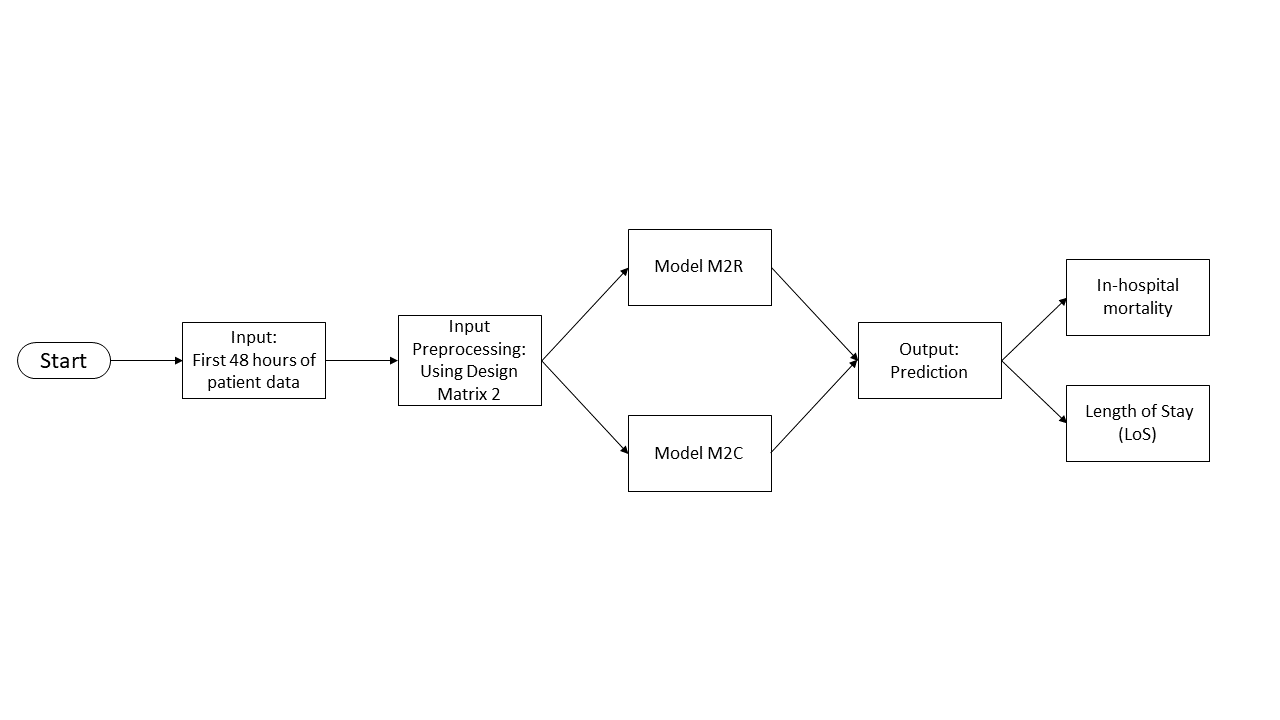

Firstly, input the first 48 hours of the patient data into either of the models, M2R or M2C. As the patient data is passed into either of the models, it will then be preprocessed using Design Matrix 2 which both models used this to preprocess input data. Design Matrix 2 transformed the input patient data in such a way that every parameters is grouped into a 12-hour bin (total of 4 bins for the first 48 hours). If a parameter is measured multiple times within a 12-hour bin, a mean of those measurement will be recorded to represent the measurement for that 12-hour bin instead. The data will then be used with Tensorflow in the Model for both M2R and M2C. 

For mortality prediction, the true positives is that a patient is predicted to die and he/she actually dies and the true negatives is that a patient is predicted to live and he/she lives. In an actual scenario which concerns life and death, this boils down to the morality for the prediction. Some patients prefer to know the 'truth', in this case, they want the actual result to be very close to the predicted one or in fact exactly the same as what was predicted and so sensitivity is very important to them. As the higher the sensitivity, the higher the chance the predicted result becomes true. They would rather be told that they are going to die and they actually die than being told that they will live, giving them false hope, but in the end die. A common myth of admission into ICU is that patients hardly have the chance of exiting alive. Thus, when one admits into the ICU, he/she is more concerned about whether he/she will die. To achieve the highest possible tpr (sensitivity) on the AUC curve, the point to choose on the curve will be as far to the right as possible. 